# Clustering NBA 3-Point Shooters Type

In [1]:
import pandas as pd
import time
import numpy as np
from math import exp, sqrt

from nba_api.stats.static import players, teams
from nba_api.stats.endpoints import leaguedashplayerptshot, leaguedashptstats, leaguedashplayerstats, synergyplaytypes, leaguedashplayershotlocations, leaguedashteamstats

from selenium import webdriver

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import StrMethodFormatter

import seaborn as sns

from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

import networkx as nx

### Pull Catch-And-Shoot and Pullup Data

In [2]:
pup_dfs = pd.DataFrame()
cs_dfs = pd.DataFrame()

for season in range(2013, 2020):
    season_param = str(season) + '-' + str(season+1)[2:]
    pup_data = leaguedashptstats.LeagueDashPtStats(season=season_param,
                                           per_mode_simple='PerGame',
                                           player_or_team='Player',
                                           pt_measure_type='PullUpShot')
    pup_df = pup_data.get_data_frames()[0]
    pup_df['SEASON'] = season_param
    time.sleep(4)
    cs_data = leaguedashptstats.LeagueDashPtStats(season=season_param,
                                           per_mode_simple='PerGame',
                                           player_or_team='Player',
                                           pt_measure_type='CatchShoot')
    cs_df = cs_data.get_data_frames()[0]
    cs_df['SEASON'] = season_param
    time.sleep(4)
    pup_dfs = pd.concat([pup_dfs, pup_df])
    cs_dfs = pd.concat([cs_dfs, cs_df])

In [3]:
print(pup_dfs.shape)
pup_dfs.tail()

(3535, 17)


,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,GP,W,L,MIN,PULL_UP_FGM,PULL_UP_FGA,PULL_UP_FG_PCT,PULL_UP_PTS,PULL_UP_FG3M,PULL_UP_FG3A,PULL_UP_FG3_PCT,PULL_UP_EFG_PCT,SEASON
524,203897,Zach LaVine,1610612741,CHI,60,20,40,34.8,2.6,7.5,0.350,7.0,1.7,4.7,0.364,0.465,2019-20
525,1629668,Zach Norvell Jr.,1610612744,GSW,5,2,3,8.2,0.0,0.2,0.000,0.0,0.0,0.0,NaN,0.000,2019-20
526,1629015,Zhaire Smith,1610612755,PHI,7,3,4,4.6,0.0,0.3,0.000,0.0,0.0,0.0,NaN,0.000,2019-20
527,1629627,Zion Williamson,1610612740,NOP,24,11,13,27.8,0.2,0.4,0.556,0.6,0.2,0.3,0.667,0.778,2019-20
528,1629597,Zylan Cheatham,1610612740,NOP,4,2,2,12.8,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,2019-20


In [4]:
print(cs_dfs.shape)
cs_dfs.tail()

(3535, 17)


,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,GP,W,L,MIN,CATCH_SHOOT_FGM,CATCH_SHOOT_FGA,CATCH_SHOOT_FG_PCT,CATCH_SHOOT_PTS,CATCH_SHOOT_FG3M,CATCH_SHOOT_FG3A,CATCH_SHOOT_FG3_PCT,CATCH_SHOOT_EFG_PCT,SEASON
524,203897,Zach LaVine,1610612741,CHI,60,20,40,34.8,1.2,3.0,0.418,3.7,1.2,2.8,0.426,0.621,2019-20
525,1629668,Zach Norvell Jr.,1610612744,GSW,5,2,3,8.2,0.6,2.0,0.300,1.8,0.6,1.6,0.375,0.450,2019-20
526,1629015,Zhaire Smith,1610612755,PHI,7,3,4,4.6,0.0,0.4,0.000,0.0,0.0,0.4,0.000,0.000,2019-20
527,1629627,Zion Williamson,1610612740,NOP,24,11,13,27.8,0.1,0.5,0.182,0.3,0.1,0.3,0.250,0.273,2019-20
528,1629597,Zylan Cheatham,1610612740,NOP,4,2,2,12.8,0.0,0.5,0.000,0.0,0.0,0.3,0.000,0.000,2019-20


In [5]:
sub_pup_df = pup_dfs[['PLAYER_ID','PLAYER_NAME','TEAM_ID','TEAM_ABBREVIATION','GP',
                      'MIN','PULL_UP_FG3M', 'PULL_UP_FG3A', 'PULL_UP_FG3_PCT']]

sub_cs_df = cs_dfs[['CATCH_SHOOT_FG3M','CATCH_SHOOT_FG3A', 
                    'CATCH_SHOOT_FG3_PCT','SEASON']]

In [6]:
shot_df = pd.concat([sub_pup_df, sub_cs_df], axis=1, sort=False)

In [7]:
shot_df.head()

,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,GP,MIN,PULL_UP_FG3M,PULL_UP_FG3A,PULL_UP_FG3_PCT,CATCH_SHOOT_FG3M,CATCH_SHOOT_FG3A,CATCH_SHOOT_FG3_PCT,SEASON
0,201985,AJ Price,1610612750,MIN,28,3.5,0.0,0.3,0.000,0.2,0.4,0.417,2013-14
1,201166,Aaron Brooks,1610612743,DEN,72,21.6,0.4,1.3,0.301,0.9,2.0,0.442,2013-14
2,201189,Aaron Gray,1610612758,SAC,37,9.6,0.0,0.0,NaN,0.0,0.0,0.000,2013-14
3,203519,Adonis Thomas,1610612755,PHI,6,6.3,0.0,0.0,NaN,0.2,0.7,0.250,2013-14
4,1733,Al Harrington,1610612764,WAS,34,15.0,0.0,0.1,0.000,0.9,2.7,0.348,2013-14


### Web-Scrape Assisted / Unassisted Stats

In [8]:
path_to_chromedriver = '/path/to/chromedriver' # Path to access a chrome driver
browser = webdriver.Chrome(executable_path=r'C:\Users\Lukar Huang\Desktop\NBA Scripts\chromedriver')

In [9]:
def create_df(player_names, player_stats):
    data = pd.DataFrame({'PLAYER': player_names,
                       'TEAM': [i[0] for i in player_stats],
                       'AGE': [i[1] for i in player_stats],
                       'GP': [i[2] for i in player_stats],
                       'W': [i[3] for i in player_stats],
                       'L': [i[4] for i in player_stats],
                       'MIN': [i[5] for i in player_stats], 
                       '%FGA_2PT': [i[6] for i in player_stats],
                       '%FGA_3PT': [i[7] for i in player_stats],
                       '%PTS_2PT': [i[8] for i in player_stats],
                       '%PTS_2PT_MR': [i[9] for i in player_stats],
                       '%PTS_3PT': [i[10] for i in player_stats],
                       '%PTS_FBPS': [i[11] for i in player_stats],
                       '%PTS_FT': [i[12] for i in player_stats],
                       '%PTS_OFFTO': [i[13] for i in player_stats],
                       '%PTS_PITP': [i[14] for i in player_stats],
                       '%2FGM_AST': [i[15] for i in player_stats],
                       '%2FGM_UAST': [i[16] for i in player_stats],
                       '%3FGM_AST': [i[17] for i in player_stats],
                       '%3FGM_UAST': [i[18] for i in player_stats],
                       '%FGM_AST': [i[19] for i in player_stats],
                       '%FGM_UAST': [i[20] for i in player_stats],
                       }
                     )
    return data

In [10]:
perc_df = pd.DataFrame()

for season in range(2013, 2020):
    season_param = str(season) + '-' + str(season+1)[2:]
    url = "https://www.nba.com/stats/players/scoring/?sort=PLAYER_NAME&dir=-1&Season=" + season_param + "&SeasonType=Regular%20Season"
    browser.get(url)
    time.sleep(2.75)
    browser.find_element_by_xpath("//option[@label='All']").click()
    time.sleep(1)
    table = browser.find_element_by_class_name('nba-stat-table__overflow')
    time.sleep(0.25)
    column_names = []
    player_names = []
    player_stats = []
    for line_id, lines in enumerate(table.text.split('\n')):
        if line_id >= 30:
            if line_id % 2 == 0:
                player_names.append(lines)
            elif line_id % 2 == 1:
                team_name = [lines[0:3]]
                lines = lines[4:]
                for i in lines.split(' '):
                    team_name.append(float(i))
                player_stats.append(team_name)
    df = create_df(player_names, player_stats)
    df['SEASON'] = season_param
    perc_df = pd.concat([perc_df, df])

In [11]:
print(perc_df.shape)
perc_df.tail()

(3535, 23)


,PLAYER,TEAM,AGE,GP,W,L,MIN,%FGA_2PT,%FGA_3PT,%PTS_2PT,...,%PTS_FT,%PTS_OFFTO,%PTS_PITP,%2FGM_AST,%2FGM_UAST,%3FGM_AST,%3FGM_UAST,%FGM_AST,%FGM_UAST,SEASON
524,Zach LaVine,CHI,25.0,60.0,20.0,40.0,34.8,59.6,40.4,46.4,...,17.5,17.8,39.6,40.6,59.4,54.9,45.1,45.5,54.5,2019-20
525,Zach Norvell Jr.,GSW,22.0,5.0,2.0,3.0,8.2,33.3,66.7,0.0,...,10.0,0.0,0.0,0.0,0.0,100.0,0.0,100.0,0.0,2019-20
526,Zhaire Smith,PHI,21.0,7.0,3.0,4.0,4.6,72.7,27.3,75.0,...,25.0,12.5,75.0,66.7,33.3,0.0,0.0,66.7,33.3,2019-20
527,Zion Williamson,NOP,19.0,24.0,11.0,13.0,27.8,96.1,3.9,75.6,...,21.1,13.1,74.4,75.5,24.5,100.0,0.0,76.2,23.8,2019-20
528,Zylan Cheatham,NOP,24.0,4.0,2.0,2.0,12.8,88.9,11.1,100.0,...,0.0,33.3,100.0,50.0,50.0,0.0,0.0,50.0,50.0,2019-20


### Position Estimates / Position Data 

In [12]:
pbp_dfs = pd.read_csv('C:/Users/Lukar Huang/Desktop/NBA Datasets/BBallRef Play-by-Play Data by Year/pbp_pe_data.csv')

pbp_dfs.head()

,Player,Pos,Age,Tm,G,MP,PG%,SG%,SF%,PF%,...,LostBall,Shoot,Off.,Shoot.1,Off..1,PGA,And1,Blkd,Position Estimate,Season
0,Quincy Acy,SF,23,TOT,63,847,NaN,16%,77%,7%,...,7,70,8,24,2,64,5,10,2.91,2013-14
1,Quincy Acy,SF,23,SAC,56,786,NaN,17%,79%,3%,...,6,67,7,21,2,53,5,10,2.83,2013-14
2,Steven Adams,C,20,OKC,81,1197,NaN,NaN,NaN,1%,...,26,68,29,51,2,97,5,13,4.99,2013-14
3,Jeff Adrien,PF,27,TOT,53,961,NaN,NaN,5%,94%,...,11,49,6,51,7,82,14,27,3.96,2013-14
4,Jeff Adrien,PF,27,MIL,28,705,NaN,NaN,NaN,99%,...,9,33,3,43,3,67,10,24,4.01,2013-14


In [13]:
pbp_df = pbp_dfs[['Player','Pos','Age','Tm','G',
                      'MP','Position Estimate','Season']]
pbp_df.head()

,Player,Pos,Age,Tm,G,MP,Position Estimate,Season
0,Quincy Acy,SF,23,TOT,63,847,2.91,2013-14
1,Quincy Acy,SF,23,SAC,56,786,2.83,2013-14
2,Steven Adams,C,20,OKC,81,1197,4.99,2013-14
3,Jeff Adrien,PF,27,TOT,53,961,3.96,2013-14
4,Jeff Adrien,PF,27,MIL,28,705,4.01,2013-14


### General Stats Data

In [14]:
gen_dfs = pd.DataFrame()

for season in range(2013, 2020):
    season_param = str(season) + '-' + str(season+1)[2:]
    gen_data = leaguedashplayerstats.LeagueDashPlayerStats(season=season_param,
                                                           per_mode_detailed='PerGame')
    gen_df = gen_data.get_data_frames()[0]
    gen_df['SEASON'] = season_param
    time.sleep(4)
    gen_dfs = pd.concat([gen_dfs, gen_df])

In [15]:
print(gen_dfs.columns)
print(gen_dfs.shape)

Index(['PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 'AGE', 'GP',
       'W', 'L', 'W_PCT', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV',
       'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS',
       'NBA_FANTASY_PTS', 'DD2', 'TD3', 'GP_RANK', 'W_RANK', 'L_RANK',
       'W_PCT_RANK', 'MIN_RANK', 'FGM_RANK', 'FGA_RANK', 'FG_PCT_RANK',
       'FG3M_RANK', 'FG3A_RANK', 'FG3_PCT_RANK', 'FTM_RANK', 'FTA_RANK',
       'FT_PCT_RANK', 'OREB_RANK', 'DREB_RANK', 'REB_RANK', 'AST_RANK',
       'TOV_RANK', 'STL_RANK', 'BLK_RANK', 'BLKA_RANK', 'PF_RANK', 'PFD_RANK',
       'PTS_RANK', 'PLUS_MINUS_RANK', 'NBA_FANTASY_PTS_RANK', 'DD2_RANK',
       'TD3_RANK', 'CFID', 'CFPARAMS', 'SEASON'],
      dtype='object')
(3535, 66)


In [16]:
gen_dfs.head()

,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,MIN,...,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,CFID,CFPARAMS,SEASON
0,201985,AJ Price,1610612750,MIN,27.0,28,15,13,0.536,3.5,...,473,468,443,208,468,234,27,5,"201985,1610612750",2013-14
1,201166,Aaron Brooks,1610612743,DEN,29.0,72,42,30,0.583,21.6,...,187,208,184,305,215,140,27,5,"201166,1610612743",2013-14
2,201189,Aaron Gray,1610612758,SAC,29.0,37,12,25,0.324,9.6,...,269,414,436,368,393,234,27,5,"201189,1610612758",2013-14
3,203519,Adonis Thomas,1610612755,PHI,21.0,6,2,4,0.333,6.3,...,389,439,409,125,452,234,27,5,"203519,1610612755",2013-14
4,1733,Al Harrington,1610612764,WAS,34.0,34,20,14,0.588,15.0,...,168,255,244,123,316,234,27,5,"1733,1610612764",2013-14


In [17]:
gen_dfs.tail()

,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,MIN,...,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,CFID,CFPARAMS,SEASON
524,203897,Zach LaVine,1610612741,CHI,25.0,60,20,40,0.333,34.8,...,162,35,13,444,28,142,29,5,"203897,1610612741",2019-20
525,1629668,Zach Norvell Jr.,1610612744,GSW,22.0,5,2,3,0.400,8.2,...,454,498,475,509,475,239,29,5,"1629668,1610612744",2019-20
526,1629015,Zhaire Smith,1610612755,PHI,21.0,7,3,4,0.429,4.6,...,486,488,510,354,512,239,29,5,"1629015,1610612755",2019-20
527,1629627,Zion Williamson,1610612740,NOP,19.0,24,11,13,0.458,27.8,...,269,16,21,79,56,142,29,5,"1629627,1610612740",2019-20
528,1629597,Zylan Cheatham,1610612740,NOP,24.0,4,2,2,0.500,12.8,...,90,513,434,524,441,239,29,5,"1629597,1610612740",2019-20


In [18]:
gen_df = gen_dfs[['PLAYER_ID','PLAYER_NAME','TEAM_ABBREVIATION',
                  'AGE','GP','MIN','FG3M','FG3A','FG3_PCT',
                  'SEASON','REB','AST','TOV','PTS',
                  'FTA','FT_PCT',]]
print(gen_df.shape)
gen_df.head()

(3535, 16)


,PLAYER_ID,PLAYER_NAME,TEAM_ABBREVIATION,AGE,GP,MIN,FG3M,FG3A,FG3_PCT,SEASON,REB,AST,TOV,PTS,FTA,FT_PCT
0,201985,AJ Price,MIN,27.0,28,3.5,0.2,0.8,0.273,2013-14,0.4,0.5,0.3,1.6,0.1,0.000
1,201166,Aaron Brooks,DEN,29.0,72,21.6,1.3,3.4,0.387,2013-14,1.9,3.2,1.6,9.0,1.3,0.874
2,201189,Aaron Gray,SAC,29.0,37,9.6,0.0,0.0,0.000,2013-14,3.0,0.6,0.8,1.8,0.5,0.550
3,203519,Adonis Thomas,PHI,21.0,6,6.3,0.2,0.8,0.200,2013-14,0.5,0.5,0.2,2.3,0.2,1.000
4,1733,Al Harrington,WAS,34.0,34,15.0,1.0,2.9,0.340,2013-14,2.4,0.8,1.0,6.6,1.0,0.771


### Playtype Data

In [19]:
os_dfs = pd.DataFrame()

for season in range(2013, 2020):
    season_param = str(season) + '-' + str(season+1)[2:]
    os_data = synergyplaytypes.SynergyPlayTypes(season=season_param,
                                                play_type_nullable='OffScreen',
                                                player_or_team_abbreviation='P',
                                                type_grouping_nullable='Offensive')
    os_df = os_data.get_data_frames()[0]
    os_df['SEASON'] = season_param
    time.sleep(4)
    os_dfs = pd.concat([os_dfs, os_df])


In [20]:
os_dfs.columns

Index(['SEASON_ID', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION',
       'TEAM_NAME', 'PLAY_TYPE', 'TYPE_GROUPING', 'PERCENTILE', 'GP',
       'POSS_PCT', 'PPP', 'FG_PCT', 'FT_POSS_PCT', 'TOV_POSS_PCT',
       'SF_POSS_PCT', 'PLUSONE_POSS_PCT', 'SCORE_POSS_PCT', 'EFG_PCT', 'POSS',
       'PTS', 'FGM', 'FGA', 'FGMX', 'SEASON'],
      dtype='object')

In [21]:
sub_os_dfs = os_dfs[['PLAYER_ID','PLAYER_NAME','TEAM_ABBREVIATION','GP',
                     'PLAY_TYPE','POSS_PCT','PPP','FG_PCT','FT_POSS_PCT',
                     'TOV_POSS_PCT','SF_POSS_PCT','EFG_PCT','POSS',
                     'FGM','FGA','SEASON']]

sub_os_dfs.head()

,PLAYER_ID,PLAYER_NAME,TEAM_ABBREVIATION,GP,PLAY_TYPE,POSS_PCT,PPP,FG_PCT,FT_POSS_PCT,TOV_POSS_PCT,SF_POSS_PCT,EFG_PCT,POSS,FGM,FGA,SEASON
0,202691,Klay Thompson,GSW,81,OffScreen,0.232,1.012,0.459,0.044,0.074,0.041,0.530,340,139,303,2013-14
1,202331,Paul George,IND,80,OffScreen,0.166,1.085,0.436,0.095,0.061,0.085,0.542,295,109,250,2013-14
2,201142,Kevin Durant,OKC,81,OffScreen,0.134,0.929,0.405,0.104,0.087,0.078,0.468,309,102,252,2013-14
3,201942,DeMar DeRozan,TOR,79,OffScreen,0.158,0.884,0.420,0.102,0.078,0.099,0.428,293,105,250,2013-14
4,201167,Arron Afflalo,ORL,73,OffScreen,0.174,1.063,0.449,0.089,0.040,0.080,0.525,224,89,198,2013-14


In [22]:
iso_dfs = pd.DataFrame()

for season in range(2013, 2020):
    season_param = str(season) + '-' + str(season+1)[2:]
    iso_data = synergyplaytypes.SynergyPlayTypes(season=season_param,
                                                play_type_nullable='Isolation',
                                                player_or_team_abbreviation='P',
                                                type_grouping_nullable='Offensive')
    iso_df = iso_data.get_data_frames()[0]
    iso_df['SEASON'] = season_param
    time.sleep(4)
    iso_dfs = pd.concat([iso_dfs, iso_df])

In [23]:
sub_iso_dfs = iso_dfs[['PLAYER_ID','PLAYER_NAME','TEAM_ABBREVIATION','GP',
                     'PLAY_TYPE','POSS_PCT','PPP','FG_PCT','FT_POSS_PCT',
                     'TOV_POSS_PCT','SF_POSS_PCT','EFG_PCT','POSS',
                     'FGM','FGA','SEASON']]

sub_iso_dfs.head()

,PLAYER_ID,PLAYER_NAME,TEAM_ABBREVIATION,GP,PLAY_TYPE,POSS_PCT,PPP,FG_PCT,FT_POSS_PCT,TOV_POSS_PCT,SF_POSS_PCT,EFG_PCT,POSS,FGM,FGA,SEASON
0,2546,Carmelo Anthony,NYK,77,Isolation,0.256,0.962,0.423,0.135,0.061,0.127,0.449,526,184,435,2013-14
1,201142,Kevin Durant,OKC,81,Isolation,0.162,1.113,0.471,0.183,0.097,0.142,0.541,372,132,280,2013-14
2,2544,LeBron James,MIA,77,Isolation,0.207,1.008,0.453,0.144,0.070,0.129,0.498,388,145,320,2013-14
3,201935,James Harden,HOU,73,Isolation,0.235,0.944,0.356,0.202,0.095,0.187,0.408,411,105,295,2013-14
4,201939,Stephen Curry,GSW,78,Isolation,0.171,0.948,0.413,0.103,0.077,0.084,0.465,310,107,259,2013-14


In [24]:
handoff_dfs = pd.DataFrame()

for season in range(2013, 2020):
    season_param = str(season) + '-' + str(season+1)[2:]
    handoff_data = synergyplaytypes.SynergyPlayTypes(season=season_param,
                                                play_type_nullable='Handoff',
                                                player_or_team_abbreviation='P',
                                                type_grouping_nullable='Offensive')
    handoff_df = handoff_data.get_data_frames()[0]
    handoff_df['SEASON'] = season_param
    time.sleep(4)
    handoff_dfs = pd.concat([handoff_dfs, handoff_df])

In [25]:
sub_handoff_dfs = handoff_dfs[['PLAYER_ID','PLAYER_NAME','TEAM_ABBREVIATION','GP',
                     'PLAY_TYPE','POSS_PCT','PPP','FG_PCT','FT_POSS_PCT',
                     'TOV_POSS_PCT','SF_POSS_PCT','EFG_PCT','POSS',
                     'FGM','FGA','SEASON']]

sub_handoff_dfs.head()

,PLAYER_ID,PLAYER_NAME,TEAM_ABBREVIATION,GP,PLAY_TYPE,POSS_PCT,PPP,FG_PCT,FT_POSS_PCT,TOV_POSS_PCT,SF_POSS_PCT,EFG_PCT,POSS,FGM,FGA,SEASON
0,201942,DeMar DeRozan,TOR,79,Handoff,0.076,1.193,0.536,0.186,0.029,0.179,0.567,140,60,112,2013-14
1,203078,Bradley Beal,WAS,73,Handoff,0.164,0.685,0.332,0.036,0.072,0.032,0.357,222,66,199,2013-14
2,201587,Nicolas Batum,POR,82,Handoff,0.111,1.089,0.510,0.097,0.145,0.081,0.589,124,49,96,2013-14
3,202323,Evan Turner,PHI,54,Handoff,0.143,0.851,0.405,0.104,0.084,0.097,0.409,154,51,126,2013-14
4,2399,Mike Dunleavy,CHI,82,Handoff,0.115,1.009,0.441,0.092,0.064,0.092,0.495,109,41,93,2013-14


In [26]:
spotup_dfs = pd.DataFrame()

for season in range(2013, 2020):
    season_param = str(season) + '-' + str(season+1)[2:]
    spotup_data = synergyplaytypes.SynergyPlayTypes(season=season_param,
                                                play_type_nullable='Spotup',
                                                player_or_team_abbreviation='P',
                                                type_grouping_nullable='Offensive')
    spotup_df = spotup_data.get_data_frames()[0]
    spotup_df['SEASON'] = season_param
    time.sleep(4)
    spotup_dfs = pd.concat([spotup_dfs, spotup_df])

In [27]:
sub_spotup_dfs = spotup_dfs[['PLAYER_ID','PLAYER_NAME','TEAM_ABBREVIATION','GP',
                     'PLAY_TYPE','POSS_PCT','PPP','FG_PCT','FT_POSS_PCT',
                     'TOV_POSS_PCT','SF_POSS_PCT','EFG_PCT','POSS',
                     'FGM','FGA','SEASON']]

sub_spotup_dfs.head()

,PLAYER_ID,PLAYER_NAME,TEAM_ABBREVIATION,GP,PLAY_TYPE,POSS_PCT,PPP,FG_PCT,FT_POSS_PCT,TOV_POSS_PCT,SF_POSS_PCT,EFG_PCT,POSS,FGM,FGA,SEASON
0,202083,Wesley Matthews,POR,82,Spotup,0.296,1.205,0.427,0.059,0.041,0.049,0.610,370,143,335,2013-14
1,2210,Richard Jefferson,UTA,82,Spotup,0.483,1.094,0.417,0.084,0.059,0.081,0.555,393,144,345,2013-14
2,2547,Chris Bosh,MIA,79,Spotup,0.334,1.055,0.461,0.060,0.060,0.060,0.535,400,165,358,2013-14
3,202718,Chandler Parsons,HOU,75,Spotup,0.303,1.084,0.448,0.073,0.068,0.065,0.562,370,145,324,2013-14
4,201975,Jodie Meeks,LAL,77,Spotup,0.307,1.145,0.423,0.086,0.050,0.071,0.574,338,126,298,2013-14


In [28]:
pr_dfs = pd.DataFrame()

for season in range(2013, 2020):
    season_param = str(season) + '-' + str(season+1)[2:]
    pr_data = synergyplaytypes.SynergyPlayTypes(season=season_param,
                                                play_type_nullable='PRBallHandler',
                                                player_or_team_abbreviation='P',
                                                type_grouping_nullable='Offensive')
    pr_df = pr_data.get_data_frames()[0]
    pr_df['SEASON'] = season_param
    time.sleep(4)
    pr_dfs = pd.concat([pr_dfs, pr_df])

In [29]:
sub_pr_dfs = pr_dfs[['PLAYER_ID','PLAYER_NAME','TEAM_ABBREVIATION','GP',
                     'PLAY_TYPE','POSS_PCT','PPP','FG_PCT','FT_POSS_PCT',
                     'TOV_POSS_PCT','SF_POSS_PCT','EFG_PCT','POSS',
                     'FGM','FGA','SEASON']]

sub_pr_dfs.head()

,PLAYER_ID,PLAYER_NAME,TEAM_ABBREVIATION,GP,PLAY_TYPE,POSS_PCT,PPP,FG_PCT,FT_POSS_PCT,TOV_POSS_PCT,SF_POSS_PCT,EFG_PCT,POSS,FGM,FGA,SEASON
0,101145,Monta Ellis,DAL,82,PRBallHandler,0.462,0.867,0.463,0.127,0.173,0.115,0.470,802,266,574,2013-14
1,201939,Stephen Curry,GSW,78,PRBallHandler,0.375,0.947,0.454,0.071,0.183,0.063,0.543,679,234,515,2013-14
2,203081,Damian Lillard,POR,82,PRBallHandler,0.431,0.886,0.395,0.125,0.119,0.115,0.443,720,218,552,2013-14
3,202322,John Wall,WAS,82,PRBallHandler,0.414,0.747,0.396,0.067,0.163,0.064,0.416,747,231,584,2013-14
4,201609,Goran Dragic,PHX,76,PRBallHandler,0.378,0.984,0.515,0.141,0.163,0.096,0.544,560,207,402,2013-14


In [30]:
pman_dfs = pd.DataFrame()

for season in range(2013, 2020):
    season_param = str(season) + '-' + str(season+1)[2:]
    pman_data = synergyplaytypes.SynergyPlayTypes(season=season_param,
                                                play_type_nullable='PRRollman',
                                                player_or_team_abbreviation='P',
                                                type_grouping_nullable='Offensive')
    pman_df = pman_data.get_data_frames()[0]
    pman_df['SEASON'] = season_param
    time.sleep(4)
    pman_dfs = pd.concat([pman_dfs, pman_df])

In [31]:
sub_pman_dfs = pman_dfs[['PLAYER_ID','PLAYER_NAME','TEAM_ABBREVIATION','GP',
                     'PLAY_TYPE','POSS_PCT','PPP','FG_PCT','FT_POSS_PCT',
                     'TOV_POSS_PCT','SF_POSS_PCT','EFG_PCT','POSS',
                     'FGM','FGA','SEASON']]

sub_pman_dfs.head()

,PLAYER_ID,PLAYER_NAME,TEAM_ABBREVIATION,GP,PLAY_TYPE,POSS_PCT,PPP,FG_PCT,FT_POSS_PCT,TOV_POSS_PCT,SF_POSS_PCT,EFG_PCT,POSS,FGM,FGA,SEASON
0,201586,Serge Ibaka,OKC,81,PRRollMan,0.296,1.052,0.543,0.078,0.066,0.078,0.543,348,165,304,2013-14
1,202326,DeMarcus Cousins,SAC,72,PRRollMan,0.189,1.069,0.551,0.184,0.103,0.184,0.551,321,136,247,2013-14
2,1717,Dirk Nowitzki,DAL,80,PRRollMan,0.163,1.223,0.546,0.068,0.044,0.052,0.619,251,124,227,2013-14
3,200746,LaMarcus Aldridge,POR,69,PRRollMan,0.184,0.971,0.484,0.067,0.054,0.061,0.486,313,135,279,2013-14
4,203076,Anthony Davis,NOP,67,PRRollMan,0.185,1.123,0.542,0.193,0.062,0.189,0.542,243,103,190,2013-14


##### Calculate Possession Per a Game for playtypes

In [32]:
sub_os_dfs['POSS/G'] = pd.to_numeric(round(sub_os_dfs['POSS'] / sub_os_dfs['GP'], 1))
sub_iso_dfs['POSS/G'] = pd.to_numeric(round(sub_iso_dfs['POSS'] / sub_iso_dfs['GP'], 1))
sub_handoff_dfs['POSS/G'] = pd.to_numeric(round(sub_handoff_dfs['POSS'] / sub_handoff_dfs['GP'], 1))
sub_spotup_dfs['POSS/G'] = pd.to_numeric(round(sub_spotup_dfs['POSS'] / sub_spotup_dfs['GP'], 1))
sub_pr_dfs['POSS/G'] = pd.to_numeric(round(sub_pr_dfs['POSS'] / sub_pr_dfs['GP'], 1))
sub_pman_dfs['POSS/G'] = pd.to_numeric(round(sub_pman_dfs['POSS'] / sub_pman_dfs['GP'], 1))

C:\Users\Lukar Huang\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Lukar Huang\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Lukar Huang\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

### Shot Location Data

In [33]:
import json
shotloc_dfs = pd.DataFrame()

for season in range(2013, 2020):
    season_param = str(season) + '-' + str(season+1)[2:]
    shotloc_data = leaguedashplayershotlocations.LeagueDashPlayerShotLocations(season=season_param,
                                                                            distance_range='By Zone',
                                                                            per_mode_detailed='PerGame',
                                                                            rank='N')
    shotloc_json = shotloc_data.get_json()
    shotloc_dict = json.loads(shotloc_json)
    headers = shotloc_dict['resultSets']['headers'][1]['columnNames']
    shotloc_data = shotloc_dict['resultSets']['rowSet']
    shotloc_df = pd.DataFrame.from_records(shotloc_data, columns=headers)
    shotloc_df['SEASON'] = season_param
    time.sleep(4)
    shotloc_dfs = pd.concat([shotloc_dfs, shotloc_df])
    
left_dfs = shotloc_dfs.iloc[:,14:17].rename(columns={'FGM':'L_FGM',
                                                     'FGA':'L_FGA',
                                                     'FG_PCT':'L_FG_PCT'})
right_dfs = shotloc_dfs.iloc[:,17:20].rename(columns={'FGM':'R_FGM',
                                                     'FGA':'R_FGA',
                                                     'FG_PCT':'R_FG_PCT'})
above_dfs = shotloc_dfs.iloc[:,20:23].rename(columns={'FGM':'A_FGM',
                                                      'FGA':'A_FGA',
                                                      'FG_PCT':'A_FG_PCT'})
    
shotloc_dfs = pd.concat([shotloc_dfs.iloc[:,0:5], left_dfs, right_dfs, above_dfs, shotloc_dfs.iloc[:,26:]], axis=1, sort=False)

In [34]:
shotloc_dfs['L_FG_PCT'] = shotloc_dfs['L_FG_PCT'] * 100
shotloc_dfs['R_FG_PCT'] = shotloc_dfs['R_FG_PCT'] * 100
shotloc_dfs['A_FG_PCT'] = shotloc_dfs['A_FG_PCT'] * 100

print(shotloc_dfs.shape)

(3535, 15)


In [35]:
shotloc_dfs.head()

,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,AGE,L_FGM,L_FGA,L_FG_PCT,R_FGM,R_FGA,R_FG_PCT,A_FGM,A_FGA,A_FG_PCT,SEASON
0,201985,AJ Price,1610612750,MIN,27.0,0.0,0.0,0.0,0.1,0.1,100.0,0.2,0.9,23.8,2013-14
1,201166,Aaron Brooks,1610612743,DEN,29.0,0.2,0.3,55.6,0.1,0.3,33.3,1.1,2.9,38.0,2013-14
2,201189,Aaron Gray,1610612758,SAC,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013-14
3,203519,Adonis Thomas,1610612755,PHI,21.0,0.0,0.3,0.0,0.0,0.3,0.0,0.2,0.5,33.3,2013-14
4,1733,Al Harrington,1610612764,WAS,34.0,0.2,0.4,41.7,0.3,0.6,46.2,0.7,2.3,30.7,2013-14


In [36]:
team_adv_dfs = pd.DataFrame()

for season in range(2013, 2020):
    season_param = str(season) + '-' + str(season+1)[2:]
    team_data = leaguedashteamstats.LeagueDashTeamStats(season=season_param,
                                                        measure_type_detailed_defense='Advanced')
    team_adv_df = team_data.get_data_frames()[0]
    team_adv_df['SEASON'] = season_param
    team_adv_dfs = pd.concat([team_adv_dfs, team_adv_df])

In [37]:
team_adv_dfs.columns

Index(['TEAM_ID', 'TEAM_NAME', 'GP', 'W', 'L', 'W_PCT', 'MIN', 'E_OFF_RATING',
       'OFF_RATING', 'E_DEF_RATING', 'DEF_RATING', 'E_NET_RATING',
       'NET_RATING', 'AST_PCT', 'AST_TO', 'AST_RATIO', 'OREB_PCT', 'DREB_PCT',
       'REB_PCT', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'E_PACE', 'PACE',
       'PACE_PER40', 'POSS', 'PIE', 'GP_RANK', 'W_RANK', 'L_RANK',
       'W_PCT_RANK', 'MIN_RANK', 'OFF_RATING_RANK', 'DEF_RATING_RANK',
       'NET_RATING_RANK', 'AST_PCT_RANK', 'AST_TO_RANK', 'AST_RATIO_RANK',
       'OREB_PCT_RANK', 'DREB_PCT_RANK', 'REB_PCT_RANK', 'TM_TOV_PCT_RANK',
       'EFG_PCT_RANK', 'TS_PCT_RANK', 'PACE_RANK', 'PIE_RANK', 'CFID',
       'CFPARAMS', 'SEASON'],
      dtype='object')

In [38]:
team_adv_dfs = team_adv_dfs[['TEAM_ID','TEAM_NAME','GP','W','L',
                             'MIN','OFF_RATING','DEF_RATING','NET_RATING',
                             'PACE','SEASON']]
print(team_adv_dfs.shape)
team_adv_dfs.head()

(210, 11)


,TEAM_ID,TEAM_NAME,GP,W,L,MIN,OFF_RATING,DEF_RATING,NET_RATING,PACE,SEASON
0,1610612737,Atlanta Hawks,82,38,44,3966.0,104.9,105.7,-0.7,95.41,2013-14
1,1610612738,Boston Celtics,82,25,57,3946.0,101.9,106.5,-4.6,94.28,2013-14
2,1610612751,Brooklyn Nets,82,44,38,3976.0,105.4,106.7,-1.3,92.42,2013-14
3,1610612766,Charlotte Bobcats,82,43,39,3981.0,103.0,103.3,-0.4,92.93,2013-14
4,1610612741,Chicago Bulls,82,48,34,3986.0,101.7,99.9,1.9,90.84,2013-14


### Merge Datasets together

In [39]:
gen_df.head(3)

,PLAYER_ID,PLAYER_NAME,TEAM_ABBREVIATION,AGE,GP,MIN,FG3M,FG3A,FG3_PCT,SEASON,REB,AST,TOV,PTS,FTA,FT_PCT
0,201985,AJ Price,MIN,27.0,28,3.5,0.2,0.8,0.273,2013-14,0.4,0.5,0.3,1.6,0.1,0.000
1,201166,Aaron Brooks,DEN,29.0,72,21.6,1.3,3.4,0.387,2013-14,1.9,3.2,1.6,9.0,1.3,0.874
2,201189,Aaron Gray,SAC,29.0,37,9.6,0.0,0.0,0.000,2013-14,3.0,0.6,0.8,1.8,0.5,0.550


In [40]:
shot_df.head(3)

,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,GP,MIN,PULL_UP_FG3M,PULL_UP_FG3A,PULL_UP_FG3_PCT,CATCH_SHOOT_FG3M,CATCH_SHOOT_FG3A,CATCH_SHOOT_FG3_PCT,SEASON
0,201985,AJ Price,1610612750,MIN,28,3.5,0.0,0.3,0.000,0.2,0.4,0.417,2013-14
1,201166,Aaron Brooks,1610612743,DEN,72,21.6,0.4,1.3,0.301,0.9,2.0,0.442,2013-14
2,201189,Aaron Gray,1610612758,SAC,37,9.6,0.0,0.0,NaN,0.0,0.0,0.000,2013-14


In [41]:
perc_df.head(3)

,PLAYER,TEAM,AGE,GP,W,L,MIN,%FGA_2PT,%FGA_3PT,%PTS_2PT,...,%PTS_FT,%PTS_OFFTO,%PTS_PITP,%2FGM_AST,%2FGM_UAST,%3FGM_AST,%3FGM_UAST,%FGM_AST,%FGM_UAST,SEASON
0,AJ Price,MIN,27.0,28.0,15.0,13.0,3.5,52.2,47.8,59.1,...,0.0,11.4,18.2,23.1,76.9,83.3,16.7,42.1,57.9,2013-14
1,Aaron Brooks,DEN,29.0,72.0,42.0,30.0,21.6,57.3,42.7,42.5,...,12.9,13.8,32.6,13.9,86.1,69.8,30.2,36.9,63.1,2013-14
2,Aaron Gray,SAC,29.0,37.0,12.0,25.0,9.6,98.4,1.6,83.1,...,16.9,10.8,73.8,66.7,33.3,0.0,0.0,66.7,33.3,2013-14


In [42]:
pbp_df.head(3)

,Player,Pos,Age,Tm,G,MP,Position Estimate,Season
0,Quincy Acy,SF,23,TOT,63,847,2.91,2013-14
1,Quincy Acy,SF,23,SAC,56,786,2.83,2013-14
2,Steven Adams,C,20,OKC,81,1197,4.99,2013-14


In [43]:
shotloc_dfs.head(3)

,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,AGE,L_FGM,L_FGA,L_FG_PCT,R_FGM,R_FGA,R_FG_PCT,A_FGM,A_FGA,A_FG_PCT,SEASON
0,201985,AJ Price,1610612750,MIN,27.0,0.0,0.0,0.0,0.1,0.1,100.0,0.2,0.9,23.8,2013-14
1,201166,Aaron Brooks,1610612743,DEN,29.0,0.2,0.3,55.6,0.1,0.3,33.3,1.1,2.9,38.0,2013-14
2,201189,Aaron Gray,1610612758,SAC,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013-14


In [44]:
sub_gen_df = gen_df[['FG3M','FG3A','FG3_PCT','REB',
                     'AST','TOV','PTS','FTA','FT_PCT',]]
sub_perc_df = perc_df[['%FGA_3PT','%3FGM_AST','%3FGM_UAST']]
sub_shotloc_dfs = shotloc_dfs[['L_FGM','L_FGA','L_FG_PCT',
                           'R_FGM','R_FGA','R_FG_PCT',
                           'A_FGM','A_FGA','A_FG_PCT']]

In [45]:
dataset = pd.concat([shot_df, sub_gen_df, sub_perc_df, sub_shotloc_dfs], axis=1, sort=False)
dataset.head(3)

,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,GP,MIN,PULL_UP_FG3M,PULL_UP_FG3A,PULL_UP_FG3_PCT,CATCH_SHOOT_FG3M,...,%3FGM_UAST,L_FGM,L_FGA,L_FG_PCT,R_FGM,R_FGA,R_FG_PCT,A_FGM,A_FGA,A_FG_PCT
0,201985,AJ Price,1610612750,MIN,28,3.5,0.0,0.3,0.000,0.2,...,16.7,0.0,0.0,0.0,0.1,0.1,100.0,0.2,0.9,23.8
1,201166,Aaron Brooks,1610612743,DEN,72,21.6,0.4,1.3,0.301,0.9,...,30.2,0.2,0.3,55.6,0.1,0.3,33.3,1.1,2.9,38.0
2,201189,Aaron Gray,1610612758,SAC,37,9.6,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0, 0.5, 'Density')

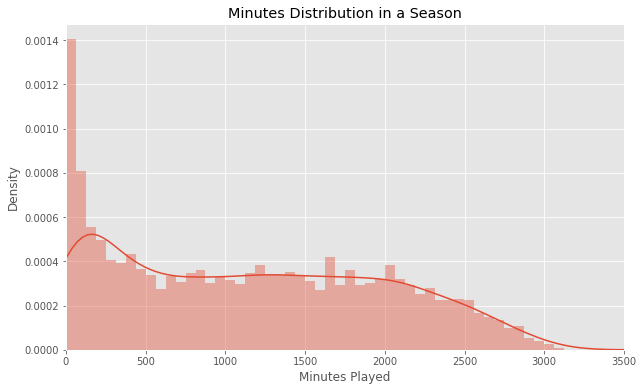

In [52]:
#get rough minutes total
dataset['MINS_TOT'] = dataset['GP'] * dataset['MIN']

#plot histogram with kde
plt.style.use('ggplot')
plt.figure(figsize=(10,6))
sns.distplot(dataset[['MINS_TOT']], kde=True, bins=50, hist=True)
plt.xlim(0, 3500)

#plot labels
plt.title('Minutes Distribution in a Season')
plt.xlabel('Minutes Played')
plt.ylabel('Density')

In [2091]:
#drop off at 500 mins, lets make the cutoff at 500 minutes, subset data by total minutes played
dataset = dataset[dataset['MINS_TOT'] >= 500]
print(dataset.shape)
dataset = dataset.reset_index(drop=True)
dataset.head(5)

(2461, 35)


,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,GP,MIN,PULL_UP_FG3M,PULL_UP_FG3A,PULL_UP_FG3_PCT,CATCH_SHOOT_FG3M,...,L_FGM,L_FGA,L_FG_PCT,R_FGM,R_FGA,R_FG_PCT,A_FGM,A_FGA,A_FG_PCT,MINS_TOT
0,201166,Aaron Brooks,1610612743,DEN,72,21.6,0.4,1.3,0.301,0.9,...,0.2,0.3,55.6,0.1,0.3,33.3,1.1,2.9,38.0,1555.2
1,1733,Al Harrington,1610612764,WAS,34,15.0,0.0,0.1,0.000,0.9,...,0.2,0.4,41.7,0.3,0.6,46.2,0.7,2.3,30.7,510.0
2,201143,Al Horford,1610612737,ATL,29,33.0,0.0,0.1,0.000,0.1,...,0.1,0.2,40.0,0.1,0.2,33.3,0.0,0.0,0.0,957.0
3,2744,Al Jefferson,1610612766,CHA,73,35.0,0.0,0.0,1.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,30.0,2555.0
4,202329,Al-Farouq Aminu,1610612740,NOP,80,25.6,0.0,0.0,0.000,0.2,...,0.1,0.2,41.7,0.1,0.3,31.6,0.0,0.2,11.8,2048.0


Text(0, 0.5, 'Density')

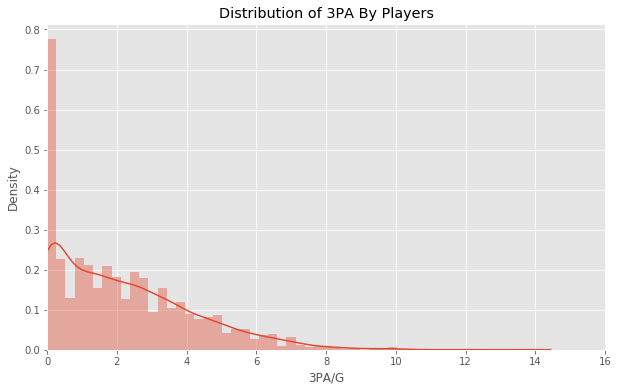

In [56]:
#plot histogram with kde
plt.figure(figsize=(10,6))
sns.distplot(dataset[['FG3A']], kde=True, bins=50, hist=True)
plt.xlim(0, 16)

#plot labels
plt.title('Distribution of 3PA By Players')
plt.xlabel('3PA/G')
plt.ylabel('Density')

In [2093]:
#look at players with more than 1 3pt attempt per a game, subset
dataset = dataset[dataset['FG3A'] >= 1.0]
print(dataset.shape)
dataset = dataset.reset_index(drop=True)
dataset.head(5)

(1864, 35)


,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,GP,MIN,PULL_UP_FG3M,PULL_UP_FG3A,PULL_UP_FG3_PCT,CATCH_SHOOT_FG3M,...,L_FGM,L_FGA,L_FG_PCT,R_FGM,R_FGA,R_FG_PCT,A_FGM,A_FGA,A_FG_PCT,MINS_TOT
0,201166,Aaron Brooks,1610612743,DEN,72,21.6,0.4,1.3,0.301,0.9,...,0.2,0.3,55.6,0.1,0.3,33.3,1.1,2.9,38.0,1555.2
1,1733,Al Harrington,1610612764,WAS,34,15.0,0.0,0.1,0.000,0.9,...,0.2,0.4,41.7,0.3,0.6,46.2,0.7,2.3,30.7,510.0
2,101187,Alan Anderson,1610612751,BKN,78,22.7,0.1,0.5,0.250,0.9,...,0.2,0.6,37.0,0.1,0.6,21.7,0.7,2.0,37.0,1770.6
3,202692,Alec Burks,1610612762,UTA,78,28.1,0.1,0.6,0.220,0.5,...,0.1,0.3,47.4,0.1,0.3,31.6,0.4,1.2,36.5,2191.8
4,203144,Alexey Shved,1610612750,MIN,63,10.5,0.2,0.7,0.310,0.3,...,0.1,0.2,25.0,0.1,0.2,60.0,0.4,1.4,28.7,661.5


In [2094]:
#drop columns
dataset = dataset.drop(columns=['MINS_TOT'])

#rename columns
dataset = dataset.rename(columns={'TEAM_ABBREVIATION':'TEAM',
                                  'PULL_UP_FG3M':'PUP_FG3M',
                                  'PULL_UP_FG3A':'PUP_FG3A',
                                  'PULL_UP_FG3_PCT':'PUP_FG3_PCT',
                                  'CATCH_SHOOT_FG3M':'CS_FG3M',
                                  'CATCH_SHOOT_FG3A':'CS_FG3A',
                                  'CATCH_SHOOT_FG3_PCT':'CS_FG3_PCT'})
print(dataset.shape)
dataset.head()

(1864, 34)


,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM,GP,MIN,PUP_FG3M,PUP_FG3A,PUP_FG3_PCT,CS_FG3M,...,%3FGM_UAST,L_FGM,L_FGA,L_FG_PCT,R_FGM,R_FGA,R_FG_PCT,A_FGM,A_FGA,A_FG_PCT
0,201166,Aaron Brooks,1610612743,DEN,72,21.6,0.4,1.3,0.301,0.9,...,30.2,0.2,0.3,55.6,0.1,0.3,33.3,1.1,2.9,38.0
1,1733,Al Harrington,1610612764,WAS,34,15.0,0.0,0.1,0.000,0.9,...,0.0,0.2,0.4,41.7,0.3,0.6,46.2,0.7,2.3,30.7
2,101187,Alan Anderson,1610612751,BKN,78,22.7,0.1,0.5,0.250,0.9,...,10.7,0.2,0.6,37.0,0.1,0.6,21.7,0.7,2.0,37.0
3,202692,Alec Burks,1610612762,UTA,78,28.1,0.1,0.6,0.220,0.5,...,18.0,0.1,0.3,47.4,0.1,0.3,31.6,0.4,1.2,36.5
4,203144,Alexey Shved,1610612750,MIN,63,10.5,0.2,0.7,0.310,0.3,...,36.7,0.1,0.2,25.0,0.1,0.2,60.0,0.4,1.4,28.7


In [2095]:
#initialize new columns
dataset['PE'] = ''
dataset['POS'] = ''

#loop through dataset
for index, row in dataset.iterrows():
    player_name = dataset.iloc[index]['PLAYER_NAME']
    season = dataset.iloc[index]['SEASON']
    name_lst = player_name.split(' ')
    if name_lst[0] in ['CJ','JJ','JR','KJ','PJ'] and name_lst[1] !=  'McCollum':
        player_name = name_lst[0][0] + '.' + name_lst[0][1] + '. '+ name_lst[1]
    if season != dataset.iloc[index-1,11] and index != 0:
        sub_pbp_df = pbp_df[pbp_df['Season'] == season].reset_index(drop=True)
    elif index == 0:
        sub_pbp_df = pbp_df[pbp_df['Season'] == season].reset_index(drop=True)
    try:
        #assign position estimate and pos
        i = sub_pbp_df.Player.to_list().index(player_name)
        pos_est = sub_pbp_df.iloc[i]['Position Estimate']
        pos = sub_pbp_df.iloc[i]['Pos']
        dataset.at[index,'PE'] = pos_est
        dataset.at[index,'POS'] = pos
    except:
        #print errors if so
        print(player_name, season)
        
#make changes to columns
dataset["PE"] = pd.to_numeric(dataset["PE"])
dataset["PUP_FG3_PCT"] = dataset["PUP_FG3_PCT"] * 100
dataset["CS_FG3_PCT"] = dataset["CS_FG3_PCT"] * 100
dataset["FG3_PCT"] = dataset["FG3_PCT"] * 100

In [2096]:
dataset.head()

,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM,GP,MIN,PUP_FG3M,PUP_FG3A,PUP_FG3_PCT,CS_FG3M,...,L_FGA,L_FG_PCT,R_FGM,R_FGA,R_FG_PCT,A_FGM,A_FGA,A_FG_PCT,PE,POS
0,201166,Aaron Brooks,1610612743,DEN,72,21.6,0.4,1.3,30.1,0.9,...,0.3,55.6,0.1,0.3,33.3,1.1,2.9,38.0,1.00,PG
1,1733,Al Harrington,1610612764,WAS,34,15.0,0.0,0.1,0.0,0.9,...,0.4,41.7,0.3,0.6,46.2,0.7,2.3,30.7,4.06,PF
2,101187,Alan Anderson,1610612751,BKN,78,22.7,0.1,0.5,25.0,0.9,...,0.6,37.0,0.1,0.6,21.7,0.7,2.0,37.0,2.75,SF
3,202692,Alec Burks,1610612762,UTA,78,28.1,0.1,0.6,22.0,0.5,...,0.3,47.4,0.1,0.3,31.6,0.4,1.2,36.5,1.99,SG
4,203144,Alexey Shved,1610612750,MIN,63,10.5,0.2,0.7,31.0,0.3,...,0.2,25.0,0.1,0.2,60.0,0.4,1.4,28.7,1.94,SG


In [2097]:
#initialize new columns
dataset['OFFSCREEN/G'] = ''
dataset['ISO/G'] = ''
dataset['HANDOFF/G'] = ''
dataset['SPOTUP/G'] = ''
dataset['PR/G'] = ''

#loop through each unique season
for season in dataset.SEASON.unique():
    temp_dataset = dataset[dataset['SEASON'] == season]
    #subset dataframes
    temp_os_df = sub_os_dfs[sub_os_dfs['SEASON'] == season]
    temp_iso_df = sub_iso_dfs[sub_iso_dfs['SEASON'] == season]
    temp_handoff_df = sub_handoff_dfs[sub_handoff_dfs['SEASON'] == season]
    temp_spotup_df = sub_spotup_dfs[sub_spotup_dfs['SEASON'] == season]
    temp_pr_df = sub_pr_dfs[sub_pr_dfs['SEASON'] == season]
    #loop through each unique subset of the dataframe by season
    for index, row in temp_dataset.iterrows():
        player_name = dataset.iloc[index]['PLAYER_NAME']
        season = dataset.iloc[index]['SEASON']
        #grab values, if no value exist, assign 0.0
        try:
            i = temp_os_df.loc[temp_os_df['PLAYER_NAME'] == player_name].index[0]
            os_g = temp_os_df.iloc[i]['POSS/G']
        except:
            os_g = 0.0
        try:
            i = temp_iso_df.loc[temp_iso_df['PLAYER_NAME'] == player_name].index[0]
            iso_g = temp_iso_df.iloc[i]['POSS/G']
        except:
            iso_g = 0.0
        try:
            i = temp_handoff_df.loc[temp_handoff_df['PLAYER_NAME'] == player_name].index[0]
            handoff_g = temp_handoff_df.iloc[i]['POSS/G']
        except:
            handoff_g = 0.0
        try:
            i = temp_spotup_df.loc[temp_spotup_df['PLAYER_NAME'] == player_name].index[0]
            spotup_g = temp_spotup_df.iloc[i]['POSS/G']
        except:
            spotup_g = 0.0
        try:
            i = temp_pr_df.loc[temp_pr_df['PLAYER_NAME'] == player_name].index[0]
            pr_g = temp_pr_df.iloc[i]['POSS/G']
        except:
            pr_g = 0.0
        #assign values at corresponding index/row
        dataset.at[index,'OFFSCREEN/G'] = os_g
        dataset.at[index,'ISO/G'] = iso_g
        dataset.at[index,'HANDOFF/G'] = handoff_g
        dataset.at[index,'SPOTUP/G'] = spotup_g
        dataset.at[index,'PR/G'] = pr_g 

In [2098]:
dataset.head()

,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM,GP,MIN,PUP_FG3M,PUP_FG3A,PUP_FG3_PCT,CS_FG3M,...,A_FGM,A_FGA,A_FG_PCT,PE,POS,OFFSCREEN/G,ISO/G,HANDOFF/G,SPOTUP/G,PR/G
0,201166,Aaron Brooks,1610612743,DEN,72,21.6,0.4,1.3,30.1,0.9,...,1.1,2.9,38.0,1.00,PG,0,1.6,0.5,1.8,5.8
1,1733,Al Harrington,1610612764,WAS,34,15.0,0.0,0.1,0.0,0.9,...,0.7,2.3,30.7,4.06,PF,0,0.6,0,3,0
2,101187,Alan Anderson,1610612751,BKN,78,22.7,0.1,0.5,25.0,0.9,...,0.7,2.0,37.0,2.75,SF,0.5,1,0.2,3.1,0.9
3,202692,Alec Burks,1610612762,UTA,78,28.1,0.1,0.6,22.0,0.5,...,0.4,1.2,36.5,1.99,SG,0.7,1.2,0.6,3,4.9
4,203144,Alexey Shved,1610612750,MIN,63,10.5,0.2,0.7,31.0,0.3,...,0.4,1.4,28.7,1.94,SG,0.2,0.4,0.2,1,1.8


In [2100]:
#initialize new columns
dataset['%3FGA_C3'] = round((dataset['L_FGA'] + dataset['R_FGA']) / dataset['FG3A'] * 100, 1)
dataset['C3_FGA'] = round((dataset['L_FGA'] + dataset['R_FGA']), 1)

In [2101]:
dataset.shape

(1864, 43)

##### Get Per 100 Possessions Stats

In [2102]:
#initialize new columns
dataset['PUP/100'] = ''
dataset['CS/100'] = ''
dataset['3P/100'] = ''
dataset['PUP_PROF'] = ''
dataset['CS_PROF'] = ''
dataset['3PT_PROF'] = ''

#loop through unique seasons
for season in dataset.SEASON.unique():
    temp_team_df = team_adv_dfs[team_adv_dfs['SEASON'] == season]
    temp_dataset = dataset[dataset['SEASON'] == season]
    #loop through each subset dataframe by season
    for index, row in temp_dataset.iterrows():
        player_name = dataset.iloc[index]['PLAYER_NAME']
        team = dataset.iloc[index]['TEAM']
        team_id = dataset.iloc[index]['TEAM_ID']
        i = temp_team_df[temp_team_df['TEAM_ID'] == team_id].index[0]
        pace = temp_team_df.iloc[i]['PACE']
        #assign values to the player data
        dataset.at[index,'PUP/100'] = round((dataset.iloc[index]['PUP_FG3A'] / 
                                             ((pace / 48) * dataset.iloc[index]['MIN'])) * 100, 1)
        dataset.at[index,'CS/100'] = round((dataset.iloc[index]['CS_FG3A'] / 
                                            ((pace / 48) * dataset.iloc[index]['MIN'])) * 100, 1)
        dataset.at[index,'3P/100'] = round((dataset.iloc[index]['FG3A'] / 
                                            ((pace / 48) * dataset.iloc[index]['MIN'])) * 100, 1)

In [2103]:
#loop through dataset
for index, row in dataset.iterrows():
    pup_threes = dataset.iloc[index]['PUP/100']
    cs_threes = dataset.loc[index]['CS/100']
    norm_threes = dataset.loc[index]['3P/100']
    #calculate proficiency stats
    dataset.at[index,'PUP_PROF'] = round(((2 / (1+exp(-pup_threes))) - 1) * dataset.iloc[index]['PUP_FG3_PCT'], 1)
    dataset.at[index,'CS_PROF'] = round(((2 / (1+exp(-cs_threes))) - 1) * dataset.iloc[index]['CS_FG3_PCT'], 1)
    dataset.at[index,'3PT_PROF'] = round(((2 / (1+exp(-norm_threes))) - 1) * dataset.iloc[index]['FG3_PCT'], 1)

In [2105]:
#convert to float type
dataset['PUP/100'] = pd.to_numeric(dataset['PUP/100'])
dataset['CS/100'] = pd.to_numeric(dataset['CS/100'])
dataset['3P/100'] = pd.to_numeric(dataset['3P/100'])
dataset['PUP_PROF'] = pd.to_numeric(dataset['PUP_PROF'])
dataset['CS_PROF'] = pd.to_numeric(dataset['CS_PROF'])
dataset['3PT_PROF'] = pd.to_numeric(dataset['3PT_PROF'])

PUP_PROF - Pullup 3s Proficiency, CS_PROF - Catch&Shoot 3s Proficiency, 3PT_PROF, 3 Point Proficiency. Formula for 3PT Proficiency was taken from Ben Taylor here: https://fansided.com/2017/08/11/nylon-calculus-measuring-creation-box-score/. That same formula is applied for catch-and-shoot and pull-up threes. This brings us closer to the "true" percentage of their actual 3PT percentage by factoring in volume / sample size.

In [2106]:
#initialize new columns
dataset['OFFSCREEN/100'] = ''
dataset['SPOTUP/100'] = ''
dataset['HANDOFF/100'] = ''
dataset['ISO/100'] = ''
dataset['PR/100'] = ''

#loop through each unique season
for season in dataset.SEASON.unique():
    temp_team_df = team_adv_dfs[team_adv_dfs['SEASON'] == season]
    temp_dataset = dataset[dataset['SEASON'] == season]
    #loop through each subset dataframe by season
    for index, row in temp_dataset.iterrows():
        player_name = dataset.iloc[index]['PLAYER_NAME']
        team = dataset.iloc[index]['TEAM']
        team_id = dataset.iloc[index]['TEAM_ID']
        i = temp_team_df[temp_team_df['TEAM_ID'] == team_id].index[0]
        pace = temp_team_df.iloc[i]['PACE']
        #assign new values to the row
        dataset.at[index,'OFFSCREEN/100'] = round((dataset.iloc[index]['OFFSCREEN/G'] / 
                                             ((pace / 48) * dataset.iloc[index]['MIN'])) * 100, 1)
        dataset.at[index,'SPOTUP/100'] = round((dataset.iloc[index]['SPOTUP/G'] / 
                                            ((pace / 48) * dataset.iloc[index]['MIN'])) * 100, 1)
        dataset.at[index,'HANDOFF/100'] = round((dataset.iloc[index]['HANDOFF/G'] / 
                                            ((pace / 48) * dataset.iloc[index]['MIN'])) * 100, 1)
        dataset.at[index,'ISO/100'] = round((dataset.iloc[index]['ISO/G'] / 
                                            ((pace / 48) * dataset.iloc[index]['MIN'])) * 100, 1)
        dataset.at[index,'PR/100'] = round((dataset.iloc[index]['PR/G'] / 
                                            ((pace / 48) * dataset.iloc[index]['MIN'])) * 100, 1)

In [2107]:
#convert columns to float type
dataset['OFFSCREEN/100'] = pd.to_numeric(dataset['OFFSCREEN/100'])
dataset['SPOTUP/100'] = pd.to_numeric(dataset['SPOTUP/100'])
dataset['HANDOFF/100'] = pd.to_numeric(dataset['HANDOFF/100'])
dataset['ISO/100'] = pd.to_numeric(dataset['ISO/100'])
dataset['PR/100'] = pd.to_numeric(dataset['PR/100'])

In [2108]:
#create new columns
dataset['%FG3A_PUP'] = round(dataset['PUP_FG3A'] / dataset['FG3A'] * 100, 1)
dataset['%FG3A_CS'] = round(dataset['CS_FG3A'] / dataset['FG3A'] * 100, 1)

#convert columns to float type
dataset['%FG3A_PUP'] = pd.to_numeric(dataset['%FG3A_PUP'])
dataset['%FG3A_CS'] = pd.to_numeric(dataset['%FG3A_CS'])

In [2109]:
dataset.head()

,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM,GP,MIN,PUP_FG3M,PUP_FG3A,PUP_FG3_PCT,CS_FG3M,...,PUP_PROF,CS_PROF,3PT_PROF,OFFSCREEN/100,SPOTUP/100,HANDOFF/100,ISO/100,PR/100,%FG3A_PUP,%FG3A_CS
0,201166,Aaron Brooks,1610612743,DEN,72,21.6,0.4,1.3,30.1,0.9,...,27.0,43.2,38.7,0.0,4.0,1.1,3.6,13.0,38.2,58.8
1,1733,Al Harrington,1610612764,WAS,34,15.0,0.0,0.1,0.0,0.9,...,0.0,34.8,34.0,0.0,10.2,0.0,2.0,0.0,3.4,93.1
2,101187,Alan Anderson,1610612751,BKN,78,22.7,0.1,0.5,25.0,0.9,...,12.5,35.3,33.9,1.1,7.1,0.5,2.3,2.1,15.6,75.0
3,202692,Alec Burks,1610612762,UTA,78,28.1,0.1,0.6,22.0,0.5,...,11.0,34.7,32.5,1.3,5.6,1.1,2.2,9.1,33.3,66.7
4,203144,Alexey Shved,1610612750,MIN,63,10.5,0.2,0.7,31.0,0.3,...,28.8,27.9,29.4,0.9,4.6,0.9,1.9,8.4,43.7,56.2


In [2617]:
#save dataset
dataset.to_csv('2013_2020_three_pt_dataset.csv')

In [2]:
dataset = pd.read_csv('2013_2020_three_pt_dataset.csv')

## K-Means Clustering

In [3]:
#looks at our data
print(dataset.shape)
dataset.head()

(1864, 57)


,Unnamed: 0,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM,GP,MIN,PUP_FG3M,PUP_FG3A,PUP_FG3_PCT,...,PUP_PROF,CS_PROF,3PT_PROF,OFFSCREEN/100,SPOTUP/100,HANDOFF/100,ISO/100,PR/100,%FG3A_PUP,%FG3A_CS
0,0,201166,Aaron Brooks,1610612743,DEN,72,21.6,0.4,1.3,30.1,...,27.0,43.2,38.7,0.0,4.0,1.1,3.6,13.0,38.2,58.8
1,1,1733,Al Harrington,1610612764,WAS,34,15.0,0.0,0.1,0.0,...,0.0,34.8,34.0,0.0,10.2,0.0,2.0,0.0,3.4,93.1
2,2,101187,Alan Anderson,1610612751,BKN,78,22.7,0.1,0.5,25.0,...,12.5,35.3,33.9,1.1,7.1,0.5,2.3,2.1,15.6,75.0
3,3,202692,Alec Burks,1610612762,UTA,78,28.1,0.1,0.6,22.0,...,11.0,34.7,32.5,1.3,5.6,1.1,2.2,9.1,33.3,66.7
4,4,203144,Alexey Shved,1610612750,MIN,63,10.5,0.2,0.7,31.0,...,28.8,27.9,29.4,0.9,4.6,0.9,1.9,8.4,43.7,56.2


In [4]:
#check for null values 
dataset.isnull().sum()

Unnamed: 0       0
PLAYER_ID        0
PLAYER_NAME      0
TEAM_ID          0
TEAM             0
GP               0
MIN              0
PUP_FG3M         0
PUP_FG3A         0
PUP_FG3_PCT      0
CS_FG3M          0
CS_FG3A          0
CS_FG3_PCT       0
SEASON           0
FG3M             0
FG3A             0
FG3_PCT          0
REB              0
AST              0
TOV              0
PTS              0
FTA              0
FT_PCT           0
%FGA_3PT         0
%3FGM_AST        0
%3FGM_UAST       0
L_FGM            0
L_FGA            0
L_FG_PCT         0
R_FGM            0
R_FGA            0
R_FG_PCT         0
A_FGM            0
A_FGA            0
A_FG_PCT         0
PE               0
POS              0
OFFSCREEN/G      0
ISO/G            0
HANDOFF/G        0
SPOTUP/G         0
PR/G             0
%3FGA_C3         0
C3_FGA           0
PUP/100          0
CS/100           0
3P/100           0
PUP_PROF         0
CS_PROF          0
3PT_PROF         0
OFFSCREEN/100    0
SPOTUP/100       0
HANDOFF/100 

In [5]:
#fill in null values with zeros
dataset = dataset.fillna(0)

dataset.head()

,Unnamed: 0,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM,GP,MIN,PUP_FG3M,PUP_FG3A,PUP_FG3_PCT,...,PUP_PROF,CS_PROF,3PT_PROF,OFFSCREEN/100,SPOTUP/100,HANDOFF/100,ISO/100,PR/100,%FG3A_PUP,%FG3A_CS
0,0,201166,Aaron Brooks,1610612743,DEN,72,21.6,0.4,1.3,30.1,...,27.0,43.2,38.7,0.0,4.0,1.1,3.6,13.0,38.2,58.8
1,1,1733,Al Harrington,1610612764,WAS,34,15.0,0.0,0.1,0.0,...,0.0,34.8,34.0,0.0,10.2,0.0,2.0,0.0,3.4,93.1
2,2,101187,Alan Anderson,1610612751,BKN,78,22.7,0.1,0.5,25.0,...,12.5,35.3,33.9,1.1,7.1,0.5,2.3,2.1,15.6,75.0
3,3,202692,Alec Burks,1610612762,UTA,78,28.1,0.1,0.6,22.0,...,11.0,34.7,32.5,1.3,5.6,1.1,2.2,9.1,33.3,66.7
4,4,203144,Alexey Shved,1610612750,MIN,63,10.5,0.2,0.7,31.0,...,28.8,27.9,29.4,0.9,4.6,0.9,1.9,8.4,43.7,56.2


In [6]:
#selecting the features we want to use 
columns_lst = ['CS_FG3A','PUP_FG3A',
               'CS_FG3_PCT','PUP_PROF','FG3_PCT',
               '%3FGM_AST','SEASON']

The features we choose are pretty self-explanatory. I did, however, use Pullup 3s Proficiency over Pullup 3s Percentage in order to adjust for players with small volume / sample size on that end, which can result in 100% or even +60% accuracy on pull-up threes. That, in itself, is not sustainable or reasonable.

In [7]:
#subset the dataset we are using to get the features
features = dataset[columns_lst]

#subset the dataset by season
features = features[features['SEASON'] == '2019-20']

#season won't be a feature, so let's drop the column of data
features = features.drop(columns=['SEASON'])

#perform feature scaling (preprocessing)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

We'll examine this dataset for only the 2019-20 season. We can't analyze seven seasons as a whole dataset unless we adjust for inflation.. Our domain knowledge tells us that 3-point volume has gone up significantly these past few years, so the amount of the 3-point attempts a player takes may seem small or large in comparison to another a player from a different season.

When we work with datasets, the range of values tend to vary across each feature. In our case, for example, 3PT% will probably vary from 10% to 55%, while the range for 3PAs per game can be from 0.5 3PA/G to 11 3PA/G. These differences in ranges, units, or scale can drastically impact our results since the machine learning algorithm will place more value on a particular feature due to these constrasts. And since k-means is a distance-based machine learning algorithm, we want to emphasize each feature equally by transforming the data onto the same playing field. Using feature scaling, also known as a preprocessing step, we transform our numerical features to be on the same scale by applying **standardiation**. On line 11 above, the *StandardScalar* class from scikit-learn's library is used to shift the mean and standard deviation of each numerical to **0** and **1** respectivally. 

##### Elbow Method: Looking at n number of clusters vs. its' model's inertia

In [8]:
#number of different cluster combination we'll try
max_n = 9

#the arguments we will pass into our k-means algorithm
kmeans_kwargs = {"init": "random",
                 "n_init": 10,
                 "max_iter": 300,
                 "random_state": 69}

#keep track of the model's inertia, the performance metric for each n amount of clusters
sse = []

#loop through and compute the model's inertia for n number of clusters
for k in range(1,max_n):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)              #call kmeans class for n number of clusters
    kmeans.fit_predict(scaled_features)                         #performs clustering on our dataset
    sse.append(kmeans.inertia_)                                 #return model's inertia

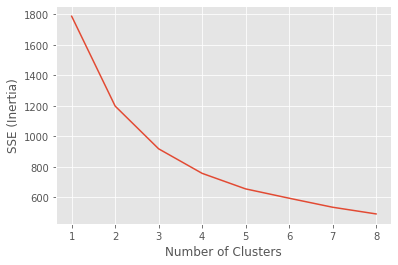

In [9]:
#plot model's inertia vs. n number of clusters
plt.style.use('ggplot')
plt.plot(range(1,max_n), sse)
plt.xticks(range(1,max_n))
plt.xlabel('Number of Clusters')
plt.ylabel('SSE (Inertia)')
plt.show()

In [10]:
kl = KneeLocator(range(1,max_n), sse, 
                 curve='convex', direction='decreasing')
print('The Elbow is at a n =', kl.elbow)

The Elbow is at a n = 3


By using the kneed package, the elbow point is indicated programmatically at n=3, however, the inertia still continues to drop quite significantly after n=3, so it's still not clear whether or not n=3 is a good number to choose for this dataset. Intuitivively too, my belief is that there are more than 3 groups / categories of 3-point shooters in our league: corner specialists, high-volume shot creators, movement shooters, catch-and-shoot specialists, wing creators, inefficient-shot creators, etc.

##### Silhouette Coefficient Method

In [11]:
#list to keep track of silhouette scores for different number of clusters
silhouette_coefficients = []

#get silhouette scores for each different number of clusters
for k in range(2, max_n):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)              #call kmeans class for n number of clusters
    kmeans.fit_predict(scaled_features)                         #perform clustering on our dataset and returns labels
    score = silhouette_score(scaled_features, kmeans.labels_)   #compute silhouette score / coefficient
    silhouette_coefficients.append(score)                       #append to list

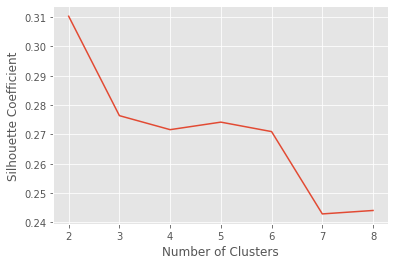

In [12]:
#plot our silhouette scores vs. n number of clusters
plt.style.use('ggplot')
plt.plot(range(2,max_n), silhouette_coefficients)
plt.xticks(range(2,max_n))
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient')
plt.show()

Let's refer to the silhouette score, or silhouette coefficient, over all instances of n we've tried. The silhouette coefficient can vary between -1 and +1. Coefficients toward +1 indicate that the instances are grouped well inside its own cluster and away from the other clusters. Meanwhile, coefficients around 0 show that the instances are close to boundary, while coefficients toward -1 mean instances may have been assigned to the wrong cluster. 

If we compare the silhouette score for each n amount of clusters, we can see n=3 is a solid choice, just as the elbow method indicated. Choosing n=2 is an even better choice, however, our intuition tells us that there should be more than 2 groups. The score then drops a bit when it hits 4, but it shoots back up at n=5, receiving a similar score to n=3. For this exercise, it seems n=6 is a better choice despite n=3 and n=5 having the slightly higher silhouette coefficient. Its silhouette coefficient is a hair away from n=5's silhouette coefficient. We can derive this conclusion based on our prior domain knowledge regarding the types of three-point shooters. To reiterate, we possibly have efficient catch-and-shoot players, inefficient catch-and-shoot players, shot-creators, inefficients shot-creators, etc. We don't know what the clusters read from the data still, however n=6 seems to be a reasonable choice provided our domain knowledge and its decent silhouette score. 

##### Plotting Silhouette Diagrams

Modified code from: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

For a more informative look at our silhouette scores, we can examine the silhouette diagram for n amount of clusters. Each group within the n amount of cluster groups is represented by a knife shape. The **height of the knife shape** shows the number of instances each cluster contains, while the **width of the knife shape** indicates the sorted silhouette coefficients of the instances in the cluster- the wider the width, the better. The vertical dashed red lines resemble the silhouette coefficients we obtained above.

For n_clusters = 2 The average silhouette_score is : 0.3103188830274153
For n_clusters = 3 The average silhouette_score is : 0.2764063784897723
For n_clusters = 4 The average silhouette_score is : 0.2708720046071272
For n_clusters = 5 The average silhouette_score is : 0.275162243798149
For n_clusters = 6 The average silhouette_score is : 0.2696996109992458
For n_clusters = 7 The average silhouette_score is : 0.24154906072076415
For n_clusters = 8 The average silhouette_score is : 0.24070492738507587


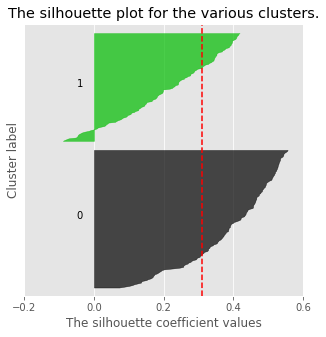

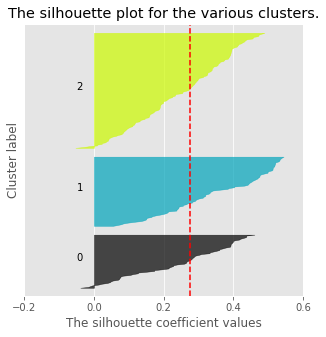

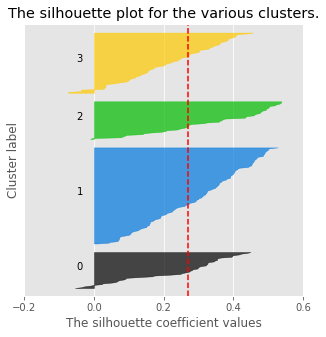

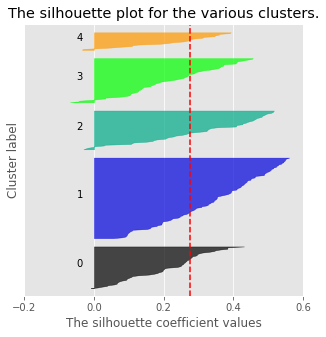

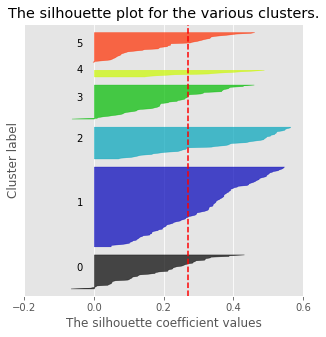

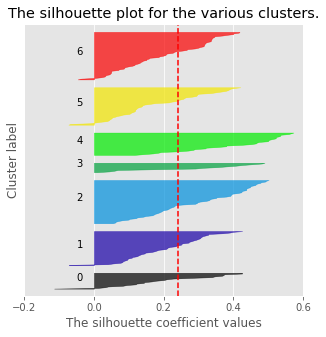

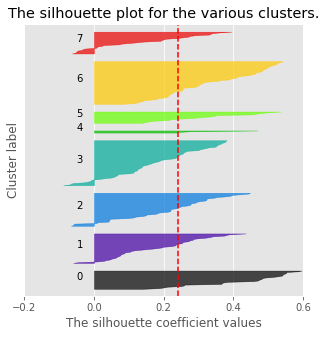

In [13]:
# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
for n_clusters in range(2,max_n):
    # Create a subplot with 1 row and 2 columns
    fig, ax = plt.subplots()
    fig.set_size_inches(5, 5)

    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 0.5]
    ax.set_xlim([-0.1, .5])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(scaled_features) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(scaled_features)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(scaled_features, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.2, 0, 0.2, 0.4, 0.6])

plt.show()

All of the diagrams show that each instance go over the dashed red line, which indicates the clusters are rather good. However, continuing off our knowledge from the silhouette coefficients, we want to look at our choices for n=3 and n=6. Setting n equal to 3 still looks solid, however, the groups seems to be somewhat unevenly distributed, favoring group 2. Meanwhile, setting n equal to 6 has solid results as well. It has fairly equally-sized clusters with one major exception being group 4, which is quite small. We can probably chalk this small group up to be the high-volume shooters and creators we witness in the league today, so let's stick with n=6.

### Choosing the Number of Clusters 

In [14]:
#apply k-means algorithmwith the k-means class and then fit the data to the scaled_features
kmeans = KMeans(n_clusters=6, **kmeans_kwargs)
kmeans.fit(scaled_features)

#print out our results
print('Cluster Labels:', np.unique(kmeans.labels_))
print('Rows:', kmeans.cluster_centers_.shape[0], 'Columns:', kmeans.cluster_centers_.shape[1])

#store cluster centers in dataframe
cluster_centers_df = pd.DataFrame(kmeans.cluster_centers_, columns=columns_lst[:-1])

#print dataframe size and show dataframe
print('Dataframe Size:', cluster_centers_df.shape)
cluster_centers_df.head()

Cluster Labels: [0 1 2 3 4 5]
Rows: 6 Columns: 6
Dataframe Size: (6, 6)


,CS_FG3A,PUP_FG3A,CS_FG3_PCT,PUP_PROF,FG3_PCT,%3FGM_AST
0,-0.030018,-0.602115,0.068756,-0.882997,0.157112,0.661873
1,-0.352611,2.631825,0.320684,1.337652,0.110508,-2.400503
2,-0.806606,-0.651729,-1.607572,-1.035973,-1.745501,0.641361
3,1.593209,0.048361,0.423208,0.527982,0.628392,0.358049
4,-0.044078,0.457224,0.865009,1.054161,0.764796,-0.507780


We choose the number of clusters to be 6 and apply kmeans to our preprocessed dataset. The cluster centers for each feature are then stored into dataframe format 

Text(0, 0.5, 'Cluster Center')

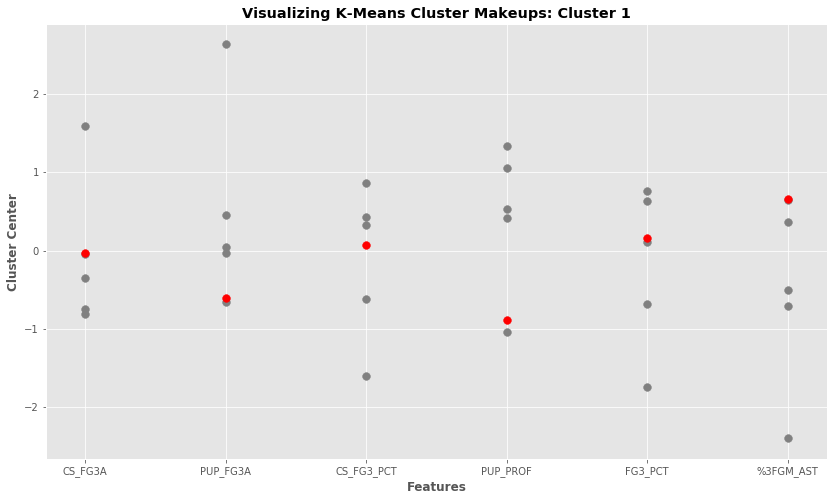

In [15]:
#set plot figure size
plt.figure(figsize=(14,8))

#loop through each row - each cluster's feature centroid
for index, row in cluster_centers_df.iterrows():
    if index != 0:
        plt.scatter(cluster_centers_df.columns, row,            #plot other cluster centroids
                    s=60, c='grey')
    else:
        cluster_centers = row                                   #save 1st cluster's centroids to plot for last

plt.scatter(cluster_centers_df.columns, cluster_centers,        #plot 1st cluster centroids
            s=60, c='red')        

#set title and labels
plt.title('Visualizing K-Means Cluster Makeups: Cluster 1', 
          weight='bold')
plt.xlabel('Features', weight='bold')
plt.ylabel('Cluster Center', weight='bold')

Cluster 1's cluster centers for each feature is highlighted above in red. This allows us to see how the kmeans algorithm decided to create this group. In this case, we see this group is compromised of efficient, high-volume catch-and-shoot players with a sprinkle of threes from pull-ups. They are also pretty efficient off the dribble as well and from 3 overall. Their threes are also somewhat mostly assisted.

### Setting up the visual for feature centroids of each cluster

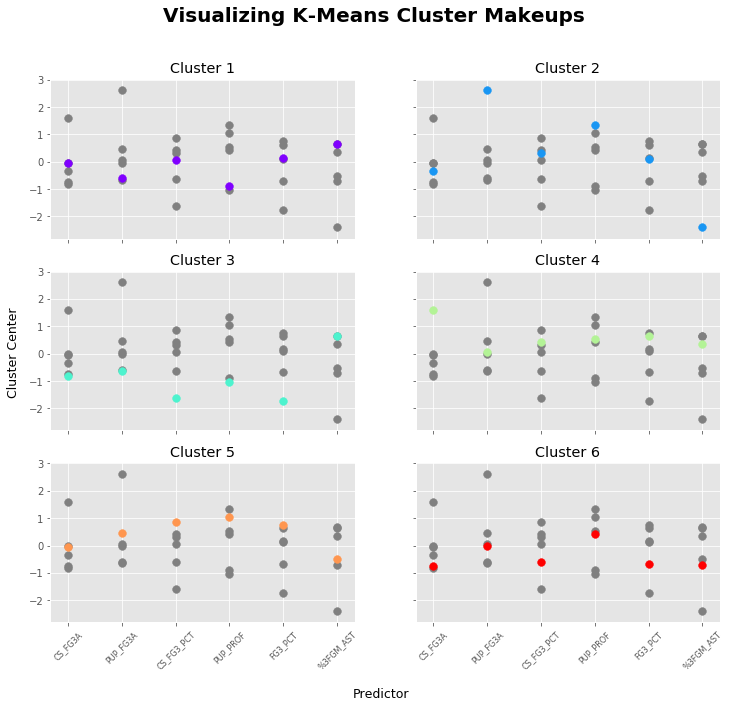

In [16]:
#setting up the sub-plot
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(12,10))

#labeling the common title, x-axis and y-axis label
fig.text(0.075,0.5,'Cluster Center', va='center', 
         rotation='vertical', fontsize=12.5)
fig.text(0.475,0.025,'Predictor', 
         va='center',fontsize='12.5')
fig.suptitle('Visualizing K-Means Cluster Makeups', 
             weight='bold', fontsize=20)

#keeping all the axs in a list
axs = [ax1,ax2,ax3,ax4,ax5,ax6]

#setting up the colormap 
colors = cm.rainbow(np.linspace(0, 1, len(axs)))

#plot the scatterplot for each cluster on each individual subplot
for i in range(len(axs)):                               #loop through all the subplots                                            
    ax = axs[i]                                         #grab axis of subplot
    ax.set_title('Cluster ' + str(i+1))                 #set subplot's title
    for index, row in cluster_centers_df.iterrows():    #loop through each row (cluster's centroids)
        if index != i:
            ax.scatter(cluster_centers_df.columns, row, #plot other cluster centroids
                       s=60, c='grey')
        else:                                           #save the cluster's centroids in question
            cluster_centers = row
    ax.scatter(cluster_centers_df.columns,              #plot the cluster's centroids in question
               cluster_centers, s=60, color=colors[i])
    ax.tick_params(axis="x", rotation=45, labelsize='8')

In [17]:
#look at our features again
features.head()

,CS_FG3A,PUP_FG3A,CS_FG3_PCT,PUP_PROF,FG3_PCT,%3FGM_AST
1566,2.6,1.1,32.5,19.5,30.8,89.0
1567,2.0,1.3,42.2,29.4,39.4,83.9
1568,2.2,0.1,38.3,4.3,37.5,97.9
1569,4.0,0.2,35.1,5.0,35.0,98.0
1570,2.0,2.5,37.7,38.5,38.5,68.1


In [18]:
#getting the cluster labels from our kmeans algorithm application
clusters_df = pd.DataFrame(kmeans.labels_, columns=['CLUSTER'])

#reset indexes features
features = features.reset_index(drop=True)

#grab player data to append to our features
labels = dataset[dataset['SEASON'] == '2019-20'][['PLAYER_NAME','TEAM','GP',
                                                  'MIN','PE','POS','SEASON',
                                                  'PUP_FG3_PCT','FG3A',
                                                  'C3_FGA','%3FGA_C3',
                                                  'A_FG_PCT',
                                                  'OFFSCREEN/G','HANDOFF/G',
                                                  'SPOTUP/G','ISO/G','PR/G']].reset_index(drop=True)


print(clusters_df.shape)
print(features.shape)
print(labels.shape)

#append our player data with our features and cluster labels
f_dataset = pd.concat([labels, features, clusters_df], axis=1, sort=False)

#check dataframe
f_dataset.head()

f_dataset.to_csv('fdataset.csv')

(298, 1)
(298, 6)
(298, 17)


### Look at each cluster's makeup

In [19]:
cluster_one = f_dataset[f_dataset['CLUSTER'] == 0].reset_index(drop=True)

cluster_one.head(10)

,PLAYER_NAME,TEAM,GP,MIN,PE,POS,SEASON,PUP_FG3_PCT,FG3A,C3_FGA,...,SPOTUP/G,ISO/G,PR/G,CS_FG3A,PUP_FG3A,CS_FG3_PCT,PUP_PROF,FG3_PCT,%3FGM_AST,CLUSTER
0,Abdel Nader,OKC,55,15.8,3.35,SF,2019-20,28.6,2.3,0.9,...,2.5,0.0,0.5,2.2,0.1,38.3,4.3,37.5,97.9,0
1,Al Horford,PHI,67,30.2,4.68,C,2019-20,33.3,4.2,0.6,...,2.5,0.4,0.0,4.0,0.2,35.1,5.0,35.0,98.0,0
2,Allen Crabbe,MIN,37,17.6,2.34,SG-SF,2019-20,0.0,3.2,1.0,...,2.2,0.0,0.0,2.9,0.4,34.0,0.0,30.3,100.0,0
3,Anthony Davis,LAL,62,34.4,4.40,PF,2019-20,15.8,3.5,0.7,...,3.1,1.9,0.7,3.1,0.3,34.4,3.1,33.0,98.6,0
4,Anthony Tolliver,MEM,55,15.9,4.28,PF,2019-20,57.1,2.6,0.8,...,2.0,0.0,0.0,2.5,0.1,33.1,8.5,33.8,98.0,0
5,Aron Baynes,PHX,42,22.2,4.88,C,2019-20,100.0,4.0,0.6,...,2.3,0.0,0.0,3.9,0.0,35.0,0.0,35.1,100.0,0
6,Avery Bradley,LAL,49,24.2,2.16,SG,2019-20,36.4,3.5,1.7,...,2.6,0.0,1.4,3.1,0.4,36.4,13.8,36.4,92.1,0
7,Bobby Portis,NYK,66,21.1,4.57,PF,2019-20,40.0,2.8,0.7,...,2.9,0.5,0.0,2.7,0.1,35.6,4.0,35.8,98.5,0
8,Brad Wanamaker,BOS,71,19.3,1.19,PG,2019-20,20.5,1.4,0.0,...,1.8,0.2,2.1,0.8,0.6,48.3,13.0,36.3,89.2,0
9,Brandon Clarke,MEM,58,22.4,3.83,PF,2019-20,0.0,1.1,0.5,...,2.0,0.3,0.0,1.1,0.0,36.5,0.0,35.9,100.0,0


In [20]:
cluster_two = f_dataset[f_dataset['CLUSTER'] == 1].reset_index(drop=True)

cluster_two.head(10)

,PLAYER_NAME,TEAM,GP,MIN,PE,POS,SEASON,PUP_FG3_PCT,FG3A,C3_FGA,...,SPOTUP/G,ISO/G,PR/G,CS_FG3A,PUP_FG3A,CS_FG3_PCT,PUP_PROF,FG3_PCT,%3FGM_AST,CLUSTER
0,Bradley Beal,WAS,57,36.0,2.14,SG,2019-20,32.9,8.4,1.1,...,2.9,2.7,9.5,4.4,3.9,38.2,32.5,35.3,63.5,1
1,Caris LeVert,BKN,45,29.6,2.16,SG,2019-20,38.7,4.9,0.6,...,2.6,3.8,8.2,1.7,3.2,31.6,38.2,36.4,46.3,1
2,Chris Paul,OKC,70,31.5,1.45,PG,2019-20,35.8,4.3,0.5,...,1.4,3.0,8.1,0.7,3.4,42.3,35.4,36.5,32.4,1
3,D'Angelo Russell,MIN,45,32.3,1.13,PG,2019-20,34.5,9.6,0.9,...,1.7,2.3,10.3,3.8,5.5,39.1,34.5,36.7,53.8,1
4,Damian Lillard,POR,66,37.5,1.00,PG,2019-20,40.4,10.2,0.5,...,1.3,4.8,13.7,2.2,7.5,40.3,40.4,40.1,28.9,1
5,Devin Booker,PHX,70,35.9,2.13,SG,2019-20,33.8,5.7,0.5,...,2.1,2.8,6.8,2.3,3.3,39.3,32.9,35.4,61.0,1
6,Devonte' Graham,CHA,63,35.1,1.61,PG,2019-20,34.4,9.3,0.7,...,2.7,1.6,8.9,3.3,5.8,42.2,34.4,37.3,54.6,1
7,Donovan Mitchell,UTA,69,34.3,1.53,SG,2019-20,32.1,6.9,1.0,...,3.5,1.9,11.6,2.7,4.1,43.2,31.9,36.6,59.5,1
8,Giannis Antetokounmpo,MIL,63,30.4,4.24,PF,2019-20,28.9,4.7,0.1,...,2.8,4.1,1.9,1.0,3.5,36.9,28.6,30.4,55.1,1
9,James Harden,HOU,68,36.5,2.33,SG,2019-20,35.0,12.4,0.6,...,1.5,14.1,5.6,1.3,10.9,41.2,35.0,35.5,17.1,1


In [21]:
cluster_three = f_dataset[f_dataset['CLUSTER'] == 2].reset_index(drop=True)

cluster_three.head(10)

,PLAYER_NAME,TEAM,GP,MIN,PE,POS,SEASON,PUP_FG3_PCT,FG3A,C3_FGA,...,SPOTUP/G,ISO/G,PR/G,CS_FG3A,PUP_FG3A,CS_FG3_PCT,PUP_PROF,FG3_PCT,%3FGM_AST,CLUSTER
0,Alex Len,SAC,55,17.6,5.00,C,2019-20,0.0,1.1,0.6,...,1.2,0.0,0.0,1.0,0.0,28.1,0.0,27.1,100.0,2
1,Alfonzo McKinnie,CLE,40,14.8,3.25,SF,2019-20,14.3,1.6,0.9,...,2.0,0.0,0.4,1.5,0.2,22.4,4.8,21.5,100.0,2
2,Chandler Hutchison,CHI,28,18.8,3.39,SF,2019-20,0.0,1.4,0.8,...,3.2,0.0,0.9,1.3,0.0,32.4,0.0,31.6,100.0,2
3,Cody Martin,CHA,48,18.8,2.78,SF,2019-20,40.0,1.6,0.8,...,1.9,0.0,0.8,1.3,0.2,20.3,9.8,23.4,94.4,2
4,Cody Zeller,CHA,58,23.1,5.00,C,2019-20,50.0,1.3,0.1,...,1.7,0.2,0.0,1.2,0.1,23.9,5.0,24.0,94.4,2
5,De'Anthony Melton,MEM,60,19.5,1.81,PG,2019-20,17.5,2.3,0.6,...,1.7,0.3,2.1,1.6,0.7,32.7,12.1,28.6,87.5,2
6,DeAndre' Bembry,ATL,43,21.3,1.96,SG,2019-20,14.3,1.5,0.7,...,2.2,0.0,1.2,1.3,0.2,24.6,2.8,23.1,100.0,2
7,Derrick Jones Jr.,MIA,59,23.3,3.10,SF,2019-20,18.2,2.2,1.4,...,2.3,0.0,0.2,2.0,0.2,28.2,3.6,28.0,97.3,2
8,Dewayne Dedmon,ATL,44,17.6,5.00,C,2019-20,40.0,2.4,0.5,...,2.4,0.0,0.0,2.3,0.1,20.2,6.0,20.6,95.5,2
9,Domantas Sabonis,IND,62,34.8,4.47,PF,2019-20,0.0,1.1,0.1,...,2.0,0.2,0.0,1.0,0.0,26.2,0.0,25.4,100.0,2


In [22]:
cluster_four = f_dataset[f_dataset['CLUSTER'] == 3].reset_index(drop=True)

cluster_four.head(10)

,PLAYER_NAME,TEAM,GP,MIN,PE,POS,SEASON,PUP_FG3_PCT,FG3A,C3_FGA,...,SPOTUP/G,ISO/G,PR/G,CS_FG3A,PUP_FG3A,CS_FG3_PCT,PUP_PROF,FG3_PCT,%3FGM_AST,CLUSTER
0,Ben McLemore,HOU,71,22.8,1.54,SF,2019-20,38.1,6.4,2.1,...,4.0,0.0,0.0,5.5,0.9,40.2,27.3,40.0,96.7,3
1,Bogdan Bogdanovic,SAC,61,28.9,2.67,SG,2019-20,28.8,7.2,1.5,...,3.6,0.9,3.7,5.0,1.9,40.7,26.5,37.2,85.4,3
2,Bojan Bogdanovic,UTA,63,33.1,3.08,SF,2019-20,39.4,7.3,2.4,...,4.2,1.8,2.7,5.0,2.3,42.6,36.9,41.4,85.7,3
3,Brandon Ingram,NOP,62,33.9,3.67,PF,2019-20,27.9,6.2,1.8,...,4.8,3.1,5.4,4.8,1.1,42.0,17.7,39.1,88.7,3
4,Bryn Forbes,SAS,63,25.1,1.77,SG,2019-20,39.6,6.0,0.6,...,4.0,0.0,1.5,4.5,1.4,39.5,34.1,38.8,93.2,3
5,Cedi Osman,CLE,65,29.4,3.15,SF,2019-20,36.8,4.9,1.1,...,0.0,0.0,0.0,3.8,1.0,38.8,24.4,38.3,89.4,3
6,Danilo Gallinari,OKC,62,29.6,4.02,PF,2019-20,35.3,7.1,0.8,...,5.0,1.6,1.8,5.5,1.4,41.8,28.9,40.5,86.0,3
7,Danny Green,LAL,68,24.8,3.10,SG,2019-20,34.6,4.8,2.0,...,3.3,0.0,0.2,4.0,0.8,36.9,22.0,36.7,97.5,3
8,Danuel House Jr.,HOU,63,30.4,3.40,SF,2019-20,36.1,5.6,2.4,...,4.5,0.2,0.3,4.7,1.0,36.5,22.9,36.3,94.6,3
9,Davis Bertans,WAS,54,29.3,4.16,PF,2019-20,40.0,8.7,0.8,...,4.1,0.0,0.4,7.4,1.3,43.1,31.3,42.4,91.5,3


In [23]:
cluster_five = f_dataset[f_dataset['CLUSTER'] == 4].reset_index(drop=True)

cluster_five.head(10)

,PLAYER_NAME,TEAM,GP,MIN,PE,POS,SEASON,PUP_FG3_PCT,FG3A,C3_FGA,...,SPOTUP/G,ISO/G,PR/G,CS_FG3A,PUP_FG3A,CS_FG3_PCT,PUP_PROF,FG3_PCT,%3FGM_AST,CLUSTER
0,Aaron Holiday,IND,66,24.5,1.00,PG,2019-20,34.1,3.3,0.7,...,2.5,0.8,3.6,2.0,1.3,42.2,29.4,39.4,83.9,4
1,Alec Burks,PHI,66,26.6,2.43,SF-SG,2019-20,39.4,4.6,0.9,...,2.1,1.1,5.8,2.0,2.5,37.7,38.5,38.5,68.1,4
2,Andrew Wiggins,GSW,54,34.4,2.97,SF,2019-20,32.0,6.2,0.9,...,3.2,2.1,8.5,3.6,2.4,35.2,29.7,33.2,77.5,4
3,Austin Rivers,HOU,68,23.4,2.06,SG,2019-20,35.9,4.0,1.0,...,2.8,2.0,1.2,2.4,1.4,36.4,31.8,35.6,70.8,4
4,Buddy Hield,SAC,72,30.8,2.23,SG,2019-20,37.4,9.6,1.9,...,3.3,1.2,5.0,5.0,4.3,41.3,37.3,39.4,72.3,4
5,CJ McCollum,POR,70,36.5,1.92,SG,2019-20,30.8,7.3,1.2,...,3.1,3.0,8.1,3.4,3.8,46.0,30.3,37.9,66.5,4
6,Coby White,CHI,65,25.8,2.05,PG,2019-20,32.8,5.8,0.8,...,3.6,0.9,5.0,3.7,2.0,37.0,31.2,35.4,75.9,4
7,Collin Sexton,CLE,65,33.0,1.79,PG,2019-20,35.0,3.9,0.4,...,2.8,1.9,7.7,2.2,1.6,42.1,28.6,38.0,74.2,4
8,D.J. Augustin,ORL,57,24.9,1.00,PG,2019-20,29.5,3.5,0.5,...,1.5,0.6,5.8,1.6,2.0,41.6,28.3,34.8,62.9,4
9,Damyean Dotson,NYK,48,17.4,2.13,SG,2019-20,30.2,3.4,0.7,...,1.7,0.3,1.1,2.3,1.1,38.9,27.6,36.2,81.4,4


In [24]:
cluster_six = f_dataset[f_dataset['CLUSTER'] == 5].reset_index(drop=True)

cluster_six.head(10)

,PLAYER_NAME,TEAM,GP,MIN,PE,POS,SEASON,PUP_FG3_PCT,FG3A,C3_FGA,...,SPOTUP/G,ISO/G,PR/G,CS_FG3A,PUP_FG3A,CS_FG3_PCT,PUP_PROF,FG3_PCT,%3FGM_AST,CLUSTER
0,Aaron Gordon,ORL,62,32.5,3.94,PF,2019-20,29.4,3.8,0.7,...,2.5,0.9,2.1,2.6,1.1,32.5,19.5,30.8,89.0,5
1,Alex Caruso,LAL,64,18.4,1.48,PG,2019-20,31.0,1.9,0.7,...,1.7,0.2,1.5,1.4,0.5,34.1,17.7,33.3,87.5,5
2,Anfernee Simons,POR,70,20.7,1.48,SG,2019-20,31.7,3.2,0.7,...,2.2,1.1,2.8,2.0,1.2,33.6,28.1,33.2,68.0,5
3,Blake Griffin,DET,18,28.5,4.13,PF,2019-20,29.3,6.2,1.4,...,3.3,1.7,3.7,2.1,3.2,23.7,29.1,24.3,59.3,5
4,De'Aaron Fox,SAC,51,32.0,1.02,PG,2019-20,26.7,3.6,0.6,...,3.0,2.5,8.7,1.5,2.0,33.3,24.2,29.2,61.1,5
5,Delon Wright,DAL,73,21.5,2.25,PG,2019-20,37.1,1.7,0.4,...,1.5,0.4,2.2,1.2,0.5,36.0,18.6,37.0,80.9,5
6,Dennis Smith Jr.,NYK,34,15.8,1.00,PG,2019-20,30.3,1.6,0.3,...,1.0,1.0,3.4,0.5,1.0,27.8,27.7,29.6,56.3,5
7,Derrick Rose,DET,50,26.0,1.02,PG,2019-20,22.8,2.9,0.4,...,1.6,1.6,10.3,0.9,1.8,42.2,21.3,30.6,64.4,5
8,Donte DiVincenzo,MIL,66,23.0,1.70,SG,2019-20,29.2,3.7,0.6,...,2.0,0.4,1.9,2.7,1.0,35.2,22.2,33.6,81.9,5
9,Emmanuel Mudiay,UTA,54,15.7,1.05,PG,2019-20,34.5,1.6,0.5,...,1.8,0.5,3.0,1.0,0.5,35.7,21.9,34.5,70.0,5


In [25]:
#inverse transform the standardscaler
inversed_cluster_centers = scaler.inverse_transform(cluster_centers_df)

#store cluster centers in dataframe
inversed_cluster_centers_df = pd.DataFrame(inversed_cluster_centers, columns=columns_lst[:-1])

#print dataframe size and show dataframe
print('Dataframe Size:', inversed_cluster_centers_df.shape)
inversed_cluster_centers_df.head()

Dataframe Size: (6, 6)


,CS_FG3A,PUP_FG3A,CS_FG3_PCT,PUP_PROF,FG3_PCT,%3FGM_AST
0,2.660396,0.301980,37.188119,7.434653,35.861386,95.977228
1,2.263636,4.890909,38.595455,34.181818,35.640909,46.336364
2,1.705263,0.231579,27.823684,5.592105,26.860526,95.644737
3,4.656818,1.225000,39.168182,24.429545,38.090909,91.052273
4,2.643103,1.805172,41.636207,30.767241,38.736207,77.017241


In [26]:
#setting up the colormap 
colors = cm.rainbow(np.linspace(0, 1, len(axs)))

#set up the list of cluster dataframes
clusters = [cluster_one, cluster_two,
            cluster_three, cluster_four,
            cluster_five, cluster_six]

cluster_str = ['Cluster One', 'Cluster Two',
               'Cluster Three', 'Cluster Four',
               'Cluster Five', 'Cluster Six']

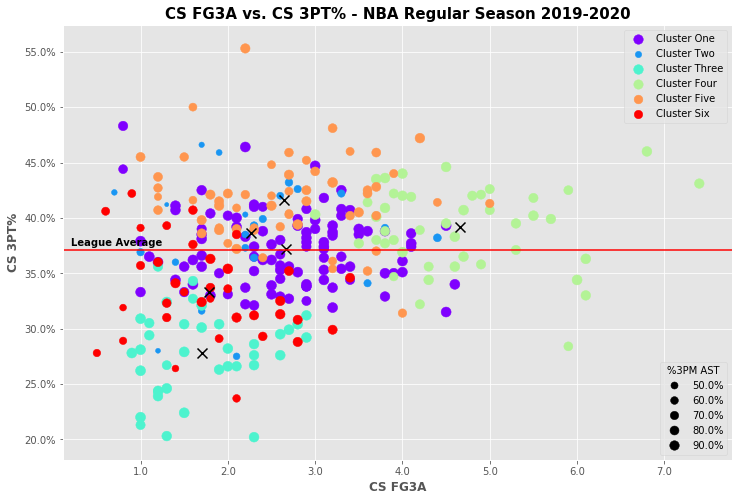

In [27]:
#set figsize, title, and axis labels
plt.figure(figsize=(12,8))
plt.title('CS FG3A vs. CS 3PT% - NBA Regular Season 2019-2020', 
          fontsize=15,
          weight='bold')
plt.xlabel('CS FG3A', weight='bold')
plt.ylabel('CS 3PT%', weight='bold')

plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) # 1 decimal place
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}%')) # 1 decimal place

#loop through the list of clusters
for i in range(len(clusters)):
    cluster = clusters[i]
    color = colors[i]
    sc = plt.scatter(cluster['CS_FG3A'], cluster['CS_FG3_PCT'],      #plot cluster's points 
                     color=color, s=cluster['%3FGM_AST'], label=cluster_str[i])
    
plt.scatter(inversed_cluster_centers_df['CS_FG3A'], 
            inversed_cluster_centers_df['CS_FG3_PCT'], 
            color='black',
            marker='x',
            s=100)

plt.axhline(y=37.11, color='r', linestyle='-')
plt.text(0.2, 37.5, 'League Average', fontweight='bold')

#plot legends
legend1 = plt.legend(loc='upper right')
plt.gca().add_artist(legend1)
plt.legend(*sc.legend_elements("sizes", num=5, fmt="{x:.1f}%"), 
           loc='lower right', title='%3PM AST')

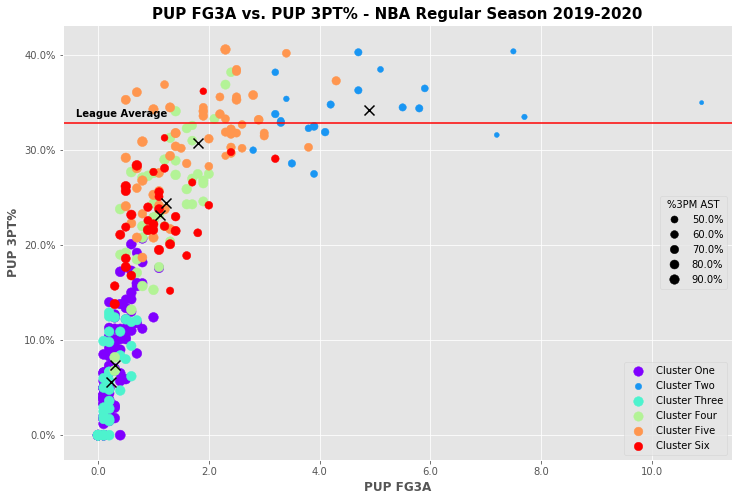

In [28]:
#set figsize, title, and axis labels

plt.figure(figsize=(12,8))
plt.title('PUP FG3A vs. PUP 3PT% - NBA Regular Season 2019-2020', 
          fontsize=15,
          weight='bold')
plt.xlabel('PUP FG3A', weight='bold')
plt.ylabel('PUP 3PT%', weight='bold')

plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) # 1 decimal place
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}%')) # 1 decimal place

#loop through the list of clusters
for i in range(len(clusters)):
    cluster = clusters[i]
    color = colors[i]
    sc = plt.scatter(cluster['PUP_FG3A'], cluster['PUP_PROF'],      #plot cluster's points 
                     color=color, s=cluster['%3FGM_AST'], label=cluster_str[i])

plt.scatter(inversed_cluster_centers_df['PUP_FG3A'], 
            inversed_cluster_centers_df['PUP_PROF'], 
            color='black',
            marker='x',
            s=100)

plt.axhline(y=32.89, color='r', linestyle='-')
plt.text(-.4, 33.5, 'League Average', fontweight='bold')

#plot legends
legend1 = plt.legend(loc='lower right')
plt.gca().add_artist(legend1)
plt.legend(*sc.legend_elements("sizes", num=5, fmt="{x:.1f}%"), 
           loc='center right', title='%3PM AST', scatteryoffsets=[0.0,20.0,40.0,60.0,80.0,100.0])

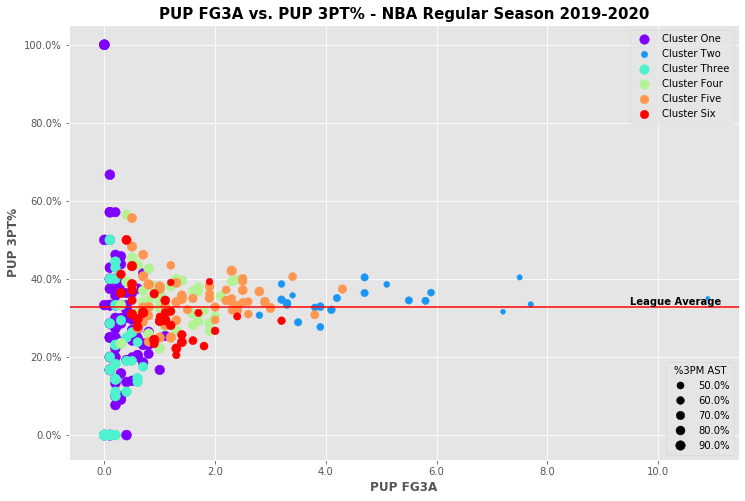

In [29]:
#set figsize, title, and axis labels
plt.figure(figsize=(12,8))
plt.title('PUP FG3A vs. PUP 3PT% - NBA Regular Season 2019-2020', 
          fontsize=15,
          weight='bold')
plt.xlabel('PUP FG3A', weight='bold')
plt.ylabel('PUP 3PT%', weight='bold')

plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) # 1 decimal place
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}%')) # 1 decimal place

#loop through the list of clusters
for i in range(len(clusters)):
    cluster = clusters[i]
    color = colors[i]
    sc = plt.scatter(cluster['PUP_FG3A'], cluster['PUP_FG3_PCT'],      #plot cluster's points 
                     color=color, s=cluster['%3FGM_AST'], label=cluster_str[i])

plt.axhline(y=32.89, color='r', linestyle='-')
plt.text(9.5, 33.5, 'League Average', fontweight='bold')    
    
#plot legends
legend1 = plt.legend()
plt.gca().add_artist(legend1)
plt.legend(*sc.legend_elements("sizes", num=5, fmt="{x:.1f}%"), 
           loc='lower right', title='%3PM AST')

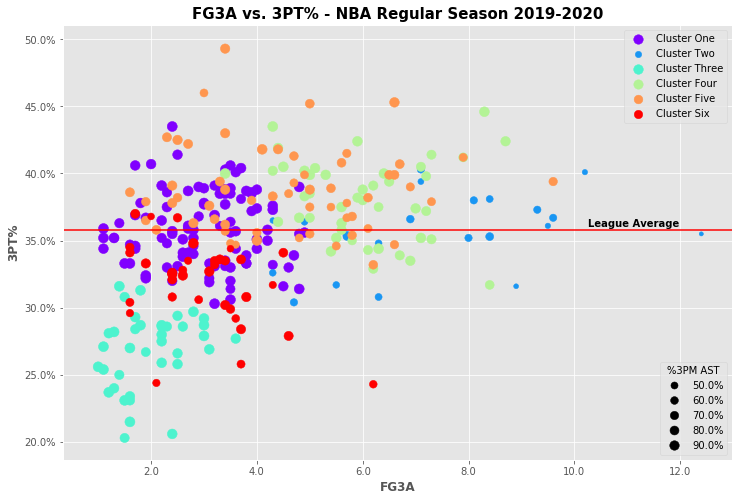

In [30]:
#set figsize, title, and axis labels
plt.figure(figsize=(12,8))
plt.title('FG3A vs. 3PT% - NBA Regular Season 2019-2020', 
          fontsize=15,
          weight='bold')
plt.xlabel('FG3A', weight='bold')
plt.ylabel('3PT%', weight='bold')

plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) # 1 decimal place
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}%')) # 1 decimal place

#loop through the list of clusters
for i in range(len(clusters)):
    cluster = clusters[i]
    color = colors[i]
    sc = plt.scatter(cluster['FG3A'], cluster['FG3_PCT'],      #plot cluster's points 
                     color=color, s=cluster['%3FGM_AST'], label=cluster_str[i])

plt.axhline(y=35.8, color='r', linestyle='-')
plt.text(10.25, 36, 'League Average', fontweight='bold')    
    
#plot legends
legend1 = plt.legend()
plt.gca().add_artist(legend1)
plt.legend(*sc.legend_elements("sizes", num=5, fmt="{x:.1f}%"), 
           loc='lower right', title='%3PM AST')

## Gaussian Mixture Models

Instead of K-Means, we'll look to use GMM, or Gaussian Mixture models, which has some advantages over the standard K-Means methodology. The GGM is a probabilistic model that assumes a normal (or Gaussian) distribution for each cluster/instance it generates, therefore each cluster has a mean and variance assigned to it. Going back to the advantages, clusters in the GMM model can have different ellipsoidal shape, size, density, and orientation. This differs dramatically from K-Means, where the method assumes a spherical shape of clusters. Much more dynamic clusters can be created as a result. Furthermore, because each cluster now has a mean and variance, each data point contains a soft assignment (probabilistic assignment to a cluster) and also a final educated assignment. Let's see how GMM behaves for our data...

In [31]:
print(dataset.columns)
dataset.head()

Index(['Unnamed: 0', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM', 'GP',
       'MIN', 'PUP_FG3M', 'PUP_FG3A', 'PUP_FG3_PCT', 'CS_FG3M', 'CS_FG3A',
       'CS_FG3_PCT', 'SEASON', 'FG3M', 'FG3A', 'FG3_PCT', 'REB', 'AST', 'TOV',
       'PTS', 'FTA', 'FT_PCT', '%FGA_3PT', '%3FGM_AST', '%3FGM_UAST', 'L_FGM',
       'L_FGA', 'L_FG_PCT', 'R_FGM', 'R_FGA', 'R_FG_PCT', 'A_FGM', 'A_FGA',
       'A_FG_PCT', 'PE', 'POS', 'OFFSCREEN/G', 'ISO/G', 'HANDOFF/G',
       'SPOTUP/G', 'PR/G', '%3FGA_C3', 'C3_FGA', 'PUP/100', 'CS/100', '3P/100',
       'PUP_PROF', 'CS_PROF', '3PT_PROF', 'OFFSCREEN/100', 'SPOTUP/100',
       'HANDOFF/100', 'ISO/100', 'PR/100', '%FG3A_PUP', '%FG3A_CS'],
      dtype='object')


,Unnamed: 0,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM,GP,MIN,PUP_FG3M,PUP_FG3A,PUP_FG3_PCT,...,PUP_PROF,CS_PROF,3PT_PROF,OFFSCREEN/100,SPOTUP/100,HANDOFF/100,ISO/100,PR/100,%FG3A_PUP,%FG3A_CS
0,0,201166,Aaron Brooks,1610612743,DEN,72,21.6,0.4,1.3,30.1,...,27.0,43.2,38.7,0.0,4.0,1.1,3.6,13.0,38.2,58.8
1,1,1733,Al Harrington,1610612764,WAS,34,15.0,0.0,0.1,0.0,...,0.0,34.8,34.0,0.0,10.2,0.0,2.0,0.0,3.4,93.1
2,2,101187,Alan Anderson,1610612751,BKN,78,22.7,0.1,0.5,25.0,...,12.5,35.3,33.9,1.1,7.1,0.5,2.3,2.1,15.6,75.0
3,3,202692,Alec Burks,1610612762,UTA,78,28.1,0.1,0.6,22.0,...,11.0,34.7,32.5,1.3,5.6,1.1,2.2,9.1,33.3,66.7
4,4,203144,Alexey Shved,1610612750,MIN,63,10.5,0.2,0.7,31.0,...,28.8,27.9,29.4,0.9,4.6,0.9,1.9,8.4,43.7,56.2


In [32]:
#features - we'll use the same features as befores
gm_columns = ['CS_FG3A','PUP_FG3A',
              'CS_FG3_PCT','PUP_PROF','FG3_PCT',
              '%3FGM_AST'
             ]

#apply to 2019-20 season
gm_features = dataset[dataset['SEASON'] == '2019-20'][gm_columns].reset_index(drop=True)

#print basic identity of our dataset
print(gm_features.shape)
scaler = StandardScaler()

#convert to standard scale
X = scaler.fit_transform(gm_features)
gm_features.head()

(298, 6)


,CS_FG3A,PUP_FG3A,CS_FG3_PCT,PUP_PROF,FG3_PCT,%3FGM_AST
0,2.6,1.1,32.5,19.5,30.8,89.0
1,2.0,1.3,42.2,29.4,39.4,83.9
2,2.2,0.1,38.3,4.3,37.5,97.9
3,4.0,0.2,35.1,5.0,35.0,98.0
4,2.0,2.5,37.7,38.5,38.5,68.1


In [33]:
#keep track of sse score for GMM models 
gm_sse = []
n_max = 15
rs = 40

#loop through each possible instance of n amount of clusters
for n in range(2, n_max+1):
    gm = GaussianMixture(n_components=n, n_init=10, random_state=rs)
    gm.fit(X)
    clusters = gm.predict(X)
    gm_sse.append(silhouette_score(X, clusters))

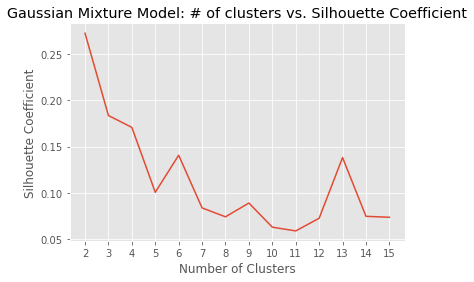

In [34]:
#plot n number of clusters vs. Silhouette Coefficient
plt.plot(range(2,n_max+1), gm_sse)
plt.title('Gaussian Mixture Model: # of clusters vs. Silhouette Coefficient')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient')
plt.xticks(range(2,n_max+1,1))
plt.show()

Interestingly enough, the silhouette coefficient shoots back up at n=13, arriving at a similar score for n=6. Let's see how the groups for n=13 pans out.

In [35]:
#get out basic player data/info
gm_labels = dataset[dataset['SEASON'] == '2019-20'][['PLAYER_NAME',
                                                     'PLAYER_ID',
                                                     'TEAM','GP',
                                                     'MIN','POS',
                                                     'FG3A'
                                                    ]].reset_index(drop=True)

#combine player data with the features we used
result = pd.concat([gm_labels, gm_features], axis=1, sort=False)

#apply GMM for n=13 
n=13
gm = GaussianMixture(n_components=n, n_init=10,random_state=rs)
gm.fit(X)
#get cluster assignments
clusters = gm.predict(X)

print('GM Converged:', gm.converged_)
print('GM iterations:', gm.n_iter_)

#use those cluster assignments in a column
result['CLUSTER'] = clusters

GM Converged: True
GM iterations: 24


In [71]:
result[result['CLUSTER'] == 12].head(50)

,PLAYER_NAME,PLAYER_ID,TEAM,GP,MIN,POS,FG3A,CS_FG3A,PUP_FG3A,CS_FG3_PCT,PUP_PROF,FG3_PCT,%3FGM_AST,CLUSTER
6,Alex Len,203458,SAC,55,17.6,C,1.1,1.0,0.0,28.1,0.0,27.1,100.0,12
7,Alfonzo McKinnie,1628035,CLE,40,14.8,SF,1.6,1.5,0.2,22.4,4.8,21.5,100.0,12
40,Cody Martin,1628998,CHA,48,18.8,SF,1.6,1.3,0.2,20.3,9.8,23.4,94.4,12
41,Cody Zeller,203469,CHA,58,23.1,C,1.3,1.2,0.1,23.9,5.0,24.0,94.4,12
60,DeAndre' Bembry,1627761,ATL,43,21.3,SG,1.5,1.3,0.2,24.6,2.8,23.1,100.0,12
72,Domantas Sabonis,1627734,IND,62,34.8,PF,1.1,1.0,0.0,26.2,0.0,25.4,100.0,12
80,Dwight Powell,203939,DAL,40,26.5,C,1.0,0.9,0.0,27.8,0.0,25.6,100.0,12
82,Elfrid Payton,203901,NYK,45,27.7,PG,1.5,1.0,0.5,21.3,8.0,20.3,85.7,12
106,Grant Williams,1629684,BOS,69,15.1,PF,1.4,1.2,0.2,24.4,6.7,25.0,87.5,12
108,Hamidou Diallo,1628977,OKC,46,19.5,SF,1.2,1.1,0.1,29.4,1.7,28.1,93.8,12


In [37]:
probabilities_df = pd.DataFrame(gm.predict_proba(scaled_features))
probabilities_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,5.386064e-132,3.022224e-05,1.882969e-38,3.009871e-12,5.469494e-15,9.999485e-01,0.0,2.007358e-05,2.325351e-130,0.0,1.178262e-06,5.505918e-25,9.595219e-33
1,2.249976e-136,9.047208e-01,3.429573e-37,7.690754e-30,1.662904e-07,1.133638e-04,0.0,9.516564e-02,5.960225e-220,0.0,1.017407e-20,7.546625e-08,1.518173e-63
2,9.890625e-01,2.849170e-10,4.020281e-197,1.235289e-11,1.093490e-02,2.635323e-06,0.0,8.693504e-24,0.000000e+00,0.0,5.419303e-13,4.389214e-245,2.653089e-24
3,3.450409e-04,5.526340e-09,1.812965e-130,1.081528e-14,9.996270e-01,1.215968e-05,0.0,5.663172e-73,0.000000e+00,0.0,1.583757e-05,4.093395e-185,5.781390e-88
4,0.000000e+00,8.667768e-15,7.465671e-10,2.490940e-141,2.576489e-156,7.986121e-31,0.0,8.140219e-37,1.978179e-04,0.0,3.919613e-44,9.998022e-01,1.977941e-145


In [38]:
gm_clusters = pd.DataFrame(clusters, columns=['Cluster'])
X_df = pd.DataFrame(X)


features_w_labels = pd.concat([X_df, gm_clusters], axis=1, sort=False)

features_w_labels.head()

,0,1,2,3,4,5,Cluster
0,-0.079124,-0.039730,-0.770464,0.118713,-0.912770,0.231443,5
1,-0.566965,0.101216,0.965934,0.940648,0.905109,-0.083179,1
2,-0.404351,-0.744456,0.267794,-1.143248,0.503485,0.780490,0
3,1.059171,-0.673983,-0.305038,-1.085132,-0.024969,0.786659,4
4,-0.566965,0.946888,0.160388,1.696164,0.714866,-1.057891,11


GMM, unlike K-Means clustering, doesn't necessarily associate itself with a "cluster centroid". Instead, the cluster centroid refers to the point of highest probability linked to the cluster in question. That point would then be considered the "cluster centroid". In this case though, we'll take our scaled features (z-scores) and average them out across each cluster to get a sense of the "cluster centroid" or the "makeup" for each cluster.

In [39]:
#get "cluster centroid" for each cluster
gm_cluster_centers = pd.DataFrame(columns=gm_columns)

for i in range(0,13):
    row = list(features_w_labels[features_w_labels['Cluster'] == i].iloc[:,:-1].mean())
    gm_cluster_centers.loc[len(gm_cluster_centers)] = row
    
print(gm_cluster_centers.shape)
gm_cluster_centers.head()

(13, 6)


,CS_FG3A,PUP_FG3A,CS_FG3_PCT,PUP_PROF,FG3_PCT,%3FGM_AST
0,-0.529699,-0.725370,-0.343078,-1.103639,-0.170734,0.721113
1,1.145560,0.017529,0.852374,0.664335,0.976451,0.337474
2,-1.114431,0.585128,-0.641577,0.779582,-0.823990,-1.810516
3,-0.543051,-0.570347,-1.103212,-0.977201,-1.393974,0.667632
4,0.504807,-0.621129,0.103430,-0.896630,0.377136,0.701975


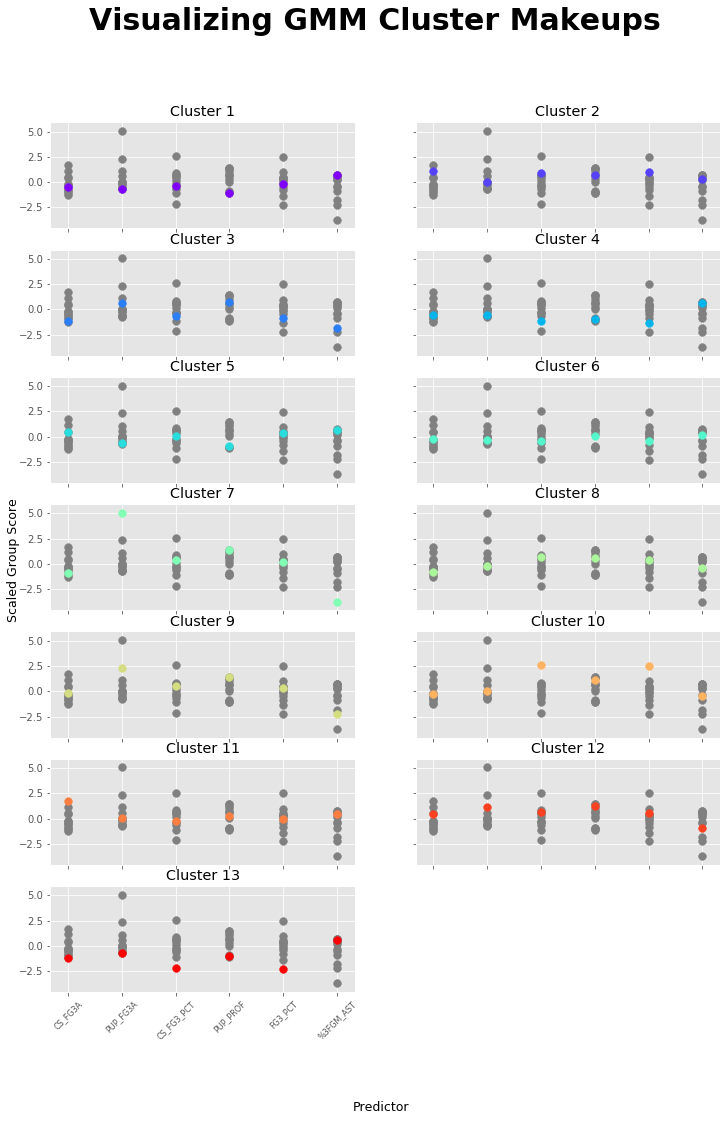

In [42]:
#setting up the sub-plot
#fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12), (ax13, ax14, ax15)) = plt.subplots(5, 3, sharex=True, sharey=True, figsize=(20,20))
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10), (ax11, ax12), (ax13, ax14)) = plt.subplots(7, 2, sharex=True, sharey=True, figsize=(12,16))

#labeling the common title, x-axis and y-axis label
fig.text(0.075,0.5,'Scaled Group Score', va='center', 
         rotation='vertical', fontsize=12.5)
fig.text(0.475,0.025,'Predictor', 
         va='center',fontsize='12.5')
fig.suptitle('Visualizing GMM Cluster Makeups', 
             weight='bold', fontsize=30)

#keeping all the axs in a list
gm_axs = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,
          ax8,ax9,ax10,ax11,ax12,ax13]

#setting up the colormap 
colors = cm.rainbow(np.linspace(0, 1, len(gm_axs)))

#plot the scatterplot for each cluster on each individual subplot
for i in range(len(gm_axs)):                            #loop through all the subplots                                            
    ax = gm_axs[i]                                      #grab axis of subplot
    ax.set_title('Cluster ' + str(i+1))                 #set subplot's title
    for index, row in gm_cluster_centers.iterrows():    #loop through each row (cluster's centroids)
        if index != i:
            ax.scatter(gm_cluster_centers.columns, row, #plot other cluster centroids
                       s=60, c='grey')
        else:                                           #save the cluster's centroids in question
            cluster_centers = row
    ax.scatter(gm_cluster_centers.columns,              #plot the cluster's centroids in question
               cluster_centers, s=60, color=colors[i])
    ax.tick_params(axis="x", rotation=45, labelsize='8')
    
#delete 14th subplot
fig.delaxes(ax14) 
#fig.delaxes(ax15)

In [2588]:
result.head()

,PLAYER_NAME,PLAYER_ID,TEAM,GP,MIN,POS,FG3A,CS_FG3A,PUP_FG3A,CS_FG3_PCT,PUP_PROF,FG3_PCT,%3FGM_AST,CLUSTER
0,Aaron Gordon,203932,ORL,62,32.5,PF,3.8,2.6,1.1,32.5,19.5,30.8,89.0,5
1,Aaron Holiday,1628988,IND,66,24.5,PG,3.3,2.0,1.3,42.2,29.4,39.4,83.9,1
2,Abdel Nader,1627846,OKC,55,15.8,SF,2.3,2.2,0.1,38.3,4.3,37.5,97.9,0
3,Al Horford,201143,PHI,67,30.2,C,4.2,4.0,0.2,35.1,5.0,35.0,98.0,4
4,Alec Burks,202692,PHI,66,26.6,SF-SG,4.6,2.0,2.5,37.7,38.5,38.5,68.1,11


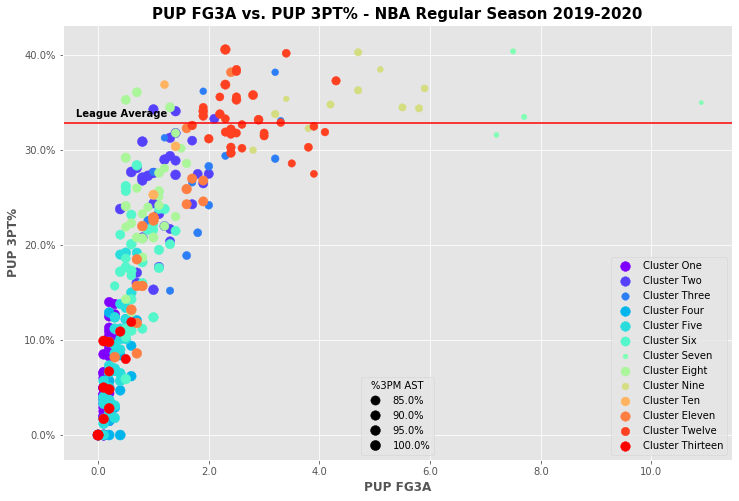

In [2589]:
gm_cluster_str = ['Cluster One', 'Cluster Two',
                  'Cluster Three', 'Cluster Four',
                  'Cluster Five', 'Cluster Six',
                  'Cluster Seven', 'Cluster Eight',
                  'Cluster Nine', 'Cluster Ten',
                  'Cluster Eleven', 'Cluster Twelve',
                  'Cluster Thirteen'
                 ]

gm_clusters = [result[result['CLUSTER'] == i] for i in range(13)]

#setting up the colormap 
gm_colors = cm.rainbow(np.linspace(0, 1, len(gm_axs)))

#set figsize, title, and axis labels

plt.figure(figsize=(12,8))
plt.title('PUP FG3A vs. PUP 3PT% - NBA Regular Season 2019-2020', 
          fontsize=15,
          weight='bold')
plt.xlabel('PUP FG3A', weight='bold')
plt.ylabel('PUP 3PT%', weight='bold')

plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) # 1 decimal place
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}%')) # 1 decimal place

#loop through the list of clusters
for i in range(len(gm_clusters)):
    cluster = gm_clusters[i]
    color = gm_colors[i]
    sc = plt.scatter(cluster['PUP_FG3A'], cluster['PUP_PROF'],      #plot cluster's points 
                     color=color, s=cluster['%3FGM_AST'], label=gm_cluster_str[i])

plt.axhline(y=32.89, color='r', linestyle='-')
plt.text(-.4, 33.5, 'League Average', fontweight='bold')

#plot legends
legend1 = plt.legend(loc='lower right')
plt.gca().add_artist(legend1)
plt.legend(*sc.legend_elements("sizes", num=5, fmt="{x:.1f}%"), 
           loc='lower center', title='%3PM AST', scatteryoffsets=[0.0,20.0,40.0,60.0,80.0,100.0])

Notice how the pull-up three practitioners (James Harden, Trae Young, Damian Lillard, and Luka Doncic) are all separately grouped from the three-point creators. GMM, in this case, helped us to further distinguish the differences between the types of three-point shooters. This may be a case of luck with the seed chosen, however, it does speak volume to the advantages GMM can have over K-Means when it comes to clustering data.

In [2607]:
#get soft classification probabilities for each cluster into a dataframe
mma = pd.DataFrame(data=gm.predict_proba(scaled_features))

#create node data frame
nodes = result[['PLAYER_ID',
                'PLAYER_NAME',
                'TEAM','POS',
                #'CS_FG3A','PUP_FG3A',
                #'CS_FG3_PCT','PUP_PROF','FG3_PCT',
                #'%3FGM_AST',
                'CLUSTER']]

#rename columns
nodes = nodes.rename(columns={'PLAYER_ID': 'nodes'})

#print properties of dataframe
print(nodes.shape)
nodes.head()

(298, 5)


,nodes,PLAYER_NAME,TEAM,POS,CLUSTER
0,203932,Aaron Gordon,ORL,PF,5
1,1628988,Aaron Holiday,IND,PG,1
2,1627846,Abdel Nader,OKC,SF,0
3,201143,Al Horford,PHI,C,4
4,202692,Alec Burks,PHI,SF-SG,11


In [2608]:
#initialize edges dataframe
edges = pd.DataFrame()

#distance between nodes
def calc_dist(a,b):
    return sqrt(sum((a - b)**2))

index = 0

#loop through nodes twice
for i in range(nodes.shape[0]):
    for j in range(nodes.shape[0]):
        if i > j:
            edge = {'id_one': nodes.iloc[i]['nodes'], #first node
                    'id_two': nodes.iloc[j]['nodes'], #second node
                    'weight': calc_dist(mma.iloc[i,:], mma.iloc[j,:]) #distance calculation
                   }
            df = pd.DataFrame(edge, index=[index])
            edges = pd.concat([edges,df])
            index += 1

print(edges.shape)
edges.head()

(44253, 3)


,id_one,id_two,weight
0,1628988,203932,1.351735
1,1627846,203932,1.406505
2,1627846,1628988,1.343853
3,201143,203932,1.413905
4,201143,1628988,1.351603


In [2609]:
#create a list of tuples of nodes and edge weights from the edges df
weighted_edges = []

for index, row in edges.iterrows():
    weighted_edges.append((edges.iloc[index,0], edges.iloc[index,1], edges.iloc[index,2]))

In [2610]:
#get clusters
clusters_lst = result.CLUSTER.tolist() #clusters.tolist()

#create graph
G = nx.Graph()

#add nodes
G.add_nodes_from(nodes.nodes.to_list())
print('Number of Nodes:', G.number_of_nodes())

#add weighted edges
G.add_weighted_edges_from(weighted_edges)
print('Number of Edges:', G.number_of_edges())

#set node attributes for cluster
nx.set_node_attributes(G, clusters_lst, 'Cluster')

#apply minimum spanning tree
T=nx.minimum_spanning_tree(G)

Number of Nodes: 298
Number of Edges: 44253


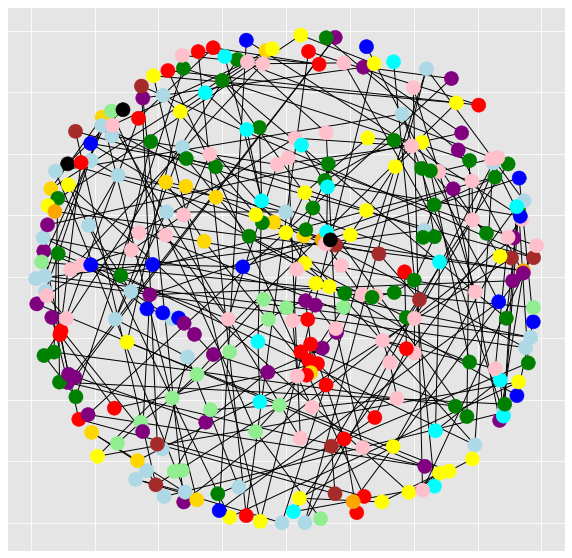

In [2611]:
#show a quick MST networknx diagram - very unorganized
plt.figure(figsize=(10,10))
nx.draw_networkx(T,  
                 with_labels=False, node_size = 200, 
                 node_color=[color_state_map[node] for node in clusters_lst]
                )
plt.show()

In [2613]:
#initialize new columns
result['RELATIONSHIP'] = ''
result['TO_NODE'] = ''
result['WEIGHT'] = ''

#loop through the nodes and add the edges
for node in sorted(T.edges(data=True)):
    from_node = node[0]
    to_node = node[1]
    weight = node[2]['weight']
    i = result.index[result['PLAYER_ID'] == from_node].to_list()[0]
    result.at[i,'RELATIONSHIP'] = str(from_node) + '-->' + str(to_node)
    result.at[i, 'WEIGHT'] = weight
    j = result.index[result['PLAYER_ID'] == to_node].to_list()[0]
    result.at[i,'TO_NODE'] = result.PLAYER_NAME.to_list()[j]

result.head()

,PLAYER_NAME,PLAYER_ID,TEAM,GP,MIN,POS,FG3A,CS_FG3A,PUP_FG3A,CS_FG3_PCT,PUP_PROF,FG3_PCT,%3FGM_AST,CLUSTER,RELATIONSHIP,TO_NODE,WEIGHT
0,Aaron Gordon,203932,ORL,62,32.5,PF,3.8,2.6,1.1,32.5,19.5,30.8,89.0,5,203932-->1628411,Wes Iwundu,3.9181e-05
1,Aaron Holiday,1628988,IND,66,24.5,PG,3.3,2.0,1.3,42.2,29.4,39.4,83.9,1,1628988-->1629056,Terence Davis,0.0375172
2,Abdel Nader,1627846,OKC,55,15.8,SF,2.3,2.2,0.1,38.3,4.3,37.5,97.9,0,1627846-->1628470,Torrey Craig,0.00255695
3,Al Horford,201143,PHI,67,30.2,C,4.2,4.0,0.2,35.1,5.0,35.0,98.0,4,201143-->1627827,Dorian Finney-Smith,8.51698e-05
4,Alec Burks,202692,PHI,66,26.6,SF-SG,4.6,2.0,2.5,37.7,38.5,38.5,68.1,11,202692-->201144,Mike Conley,0.000250582


In [2614]:
#save our results
result.to_csv('2019-20_3PT_GGM_Model_Results.csv')
nodes.to_csv('nodes.csv')
edges.to_csv('edges.csv')